In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Dropout,Flatten
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from tensorflow.keras.layers import Input, Lambda
import tensorflow.keras.backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tqdm import tqdm
from sklearn.metrics import r2_score
import lightgbm as lgb  # LightGBM gradient boosting framework
import catboost as ctb
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
from catboost import EFeaturesSelectionAlgorithm, EShapCalcType

In [2]:
data = pd.read_csv('../data/train.csv')
data.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4


In [3]:
train_stock_0 = data.query('stock_id == 0').iloc[:,3:-2]

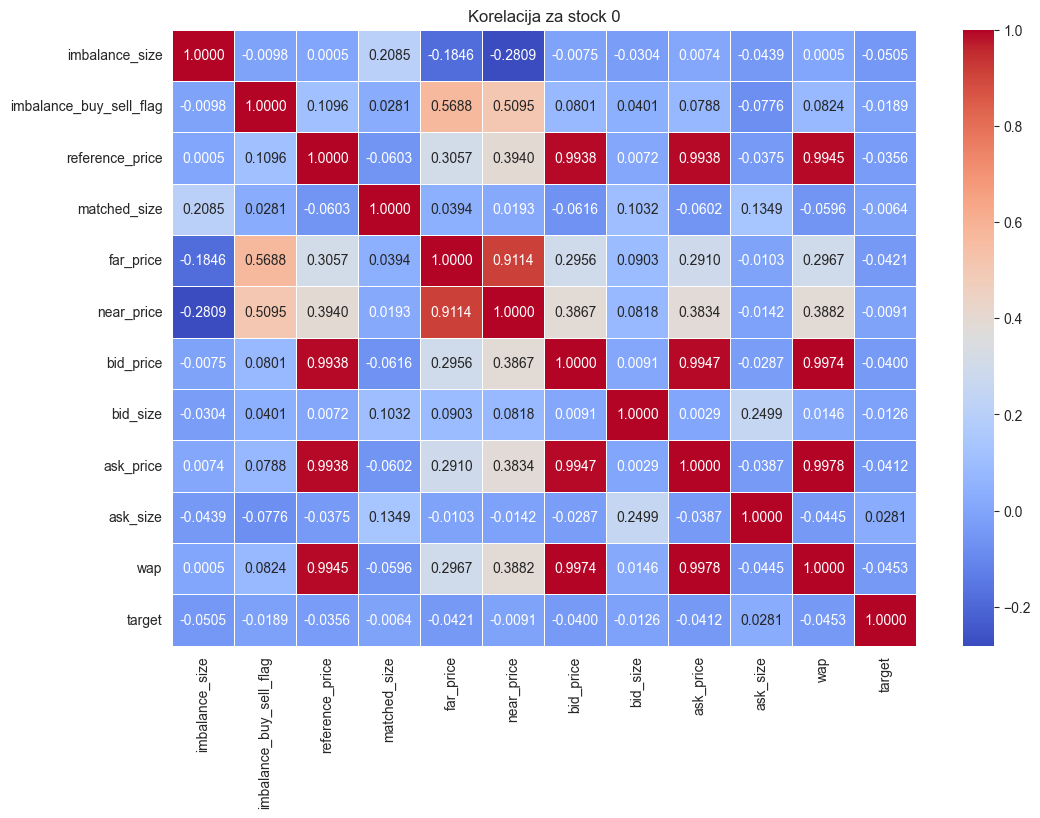

In [4]:
correlation_matrix = train_stock_0.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".4f", linewidths=.5)
plt.title('Korelacija za stock 0')
plt.show()

In [5]:
data = data.sort_values(by=['stock_id', 'date_id', 'seconds_in_bucket', 'time_id'])
data.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
191,0,0,10,1299772.70,1,1.000026,15261106.63,NaN,NaN,0.999812,13996.50,1.000026,23519.16,0.999892,0.389814,1,0_10_0
382,0,0,20,1299772.70,1,0.999919,15261106.63,NaN,NaN,0.999812,4665.50,0.999919,12131.60,0.999842,4.220009,2,0_20_0
573,0,0,30,1299772.70,1,1.000133,15261106.63,NaN,NaN,1.000026,55998.00,1.000133,46203.30,1.000085,5.450249,3,0_30_0
764,0,0,40,1218204.43,1,1.000455,15342674.90,NaN,NaN,1.000241,14655.95,1.000455,26610.45,1.000317,3.169775,4,0_40_0


In [6]:
data = data.drop(columns=['row_id', 'time_id'])
data.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704
191,0,0,10,1299772.70,1,1.000026,15261106.63,NaN,NaN,0.999812,13996.50,1.000026,23519.16,0.999892,0.389814
382,0,0,20,1299772.70,1,0.999919,15261106.63,NaN,NaN,0.999812,4665.50,0.999919,12131.60,0.999842,4.220009
573,0,0,30,1299772.70,1,1.000133,15261106.63,NaN,NaN,1.000026,55998.00,1.000133,46203.30,1.000085,5.450249
764,0,0,40,1218204.43,1,1.000455,15342674.90,NaN,NaN,1.000241,14655.95,1.000455,26610.45,1.000317,3.169775


In [7]:
data_average_price_NAN = data.copy()  # Make a copy to avoid chained assignment issues

average_prices = data_average_price_NAN[['bid_price', 'ask_price']].mean(axis=1)

# Fill NaN values in 'far_price' and 'near_price' with average_prices
data_average_price_NAN['far_price'] = data_average_price_NAN['far_price'].fillna(average_prices)
data_average_price_NAN['near_price'] = data_average_price_NAN['near_price'].fillna(average_prices)

data_average_price_NAN.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target
0,0,0,0,3180602.69,1,0.999812,13380276.64,0.999919,0.999919,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704
191,0,0,10,1299772.70,1,1.000026,15261106.63,0.999919,0.999919,0.999812,13996.50,1.000026,23519.16,0.999892,0.389814
382,0,0,20,1299772.70,1,0.999919,15261106.63,0.999866,0.999866,0.999812,4665.50,0.999919,12131.60,0.999842,4.220009
573,0,0,30,1299772.70,1,1.000133,15261106.63,1.000080,1.000080,1.000026,55998.00,1.000133,46203.30,1.000085,5.450249
764,0,0,40,1218204.43,1,1.000455,15342674.90,1.000348,1.000348,1.000241,14655.95,1.000455,26610.45,1.000317,3.169775


In [8]:
data_average_price_NAN = data_average_price_NAN.dropna()

In [9]:
print(data_average_price_NAN.isna().any())

stock_id                   False
date_id                    False
seconds_in_bucket          False
imbalance_size             False
imbalance_buy_sell_flag    False
reference_price            False
matched_size               False
far_price                  False
near_price                 False
bid_price                  False
bid_size                   False
ask_price                  False
ask_size                   False
wap                        False
target                     False
dtype: bool


In [13]:
NN_data = data_average_price_NAN.copy(deep=True)
RNN_data = data_average_price_NAN.copy(deep=True)
FRNN_data = data_average_price_NAN.copy(deep=True)
CNN2_data = data_average_price_NAN.copy(deep=True) #little feature eng
RNN2_data = data_average_price_NAN.copy(deep=True) #little feature eng
BestNN_data = data_average_price_NAN.copy(deep=True) #a lot of feature eng + boost

In [14]:
def iscrtaj_model(history):
    plt.plot(history.history["loss"], label="trening loss")
    plt.plot(history.history["val_loss"], label="validation loss")
    plt.title("Progress treninga")
    plt.ylabel("accuracy/loss")
    plt.xlabel("epoch")
    plt.legend(loc="upper left")
    plt.show()
    print("LOSS ON VALIDATION =", min(history.history["val_loss"]))

In [15]:
def plot_target_graph(model, X_test, Y_test):
    Y_pred = model.predict(X_test)
    plt.plot(Y_pred, color='blue', label='Predicted')
    plt.plot(Y_test, color='red', label='Actual')
    print(Y_test)
    plt.xlabel('Indexes')
    plt.ylabel('Values')
    plt.title('Predicted vs Actual')
    plt.legend()
    plt.show()


In [16]:
num_stocks = len(data_average_price_NAN['stock_id'].unique())
print(num_stocks)
num_dates = len(data_average_price_NAN['date_id'].unique())
print(num_dates)

200
481


In [59]:
simple_mapping = {
    1: 0.1,
    0: 0,
    -1: -0.1
}
train = NN_data[(NN_data['date_id'] == num_dates - 1)]
train['baseline_prediction'] = 0
train['simple_prediction'] = train['imbalance_buy_sell_flag'].map(simple_mapping)
baseline_mae = (train['baseline_prediction'] - train['target']).abs().mean()
simple_prediction_mae = (train['simple_prediction'] - train['target']).abs().mean()

print(baseline_mae, simple_prediction_mae)
print('MAE improvement in basis points: ', (baseline_mae - simple_prediction_mae))
train.head()

4.900187414867273 4.900993269737454
MAE improvement in basis points:  -0.0008058548701814772


C:\Users\eminm\AppData\Local\Temp\ipykernel_8516\1120481095.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['baseline_prediction'] = 0
C:\Users\eminm\AppData\Local\Temp\ipykernel_8516\1120481095.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['simple_prediction'] = train['imbalance_buy_sell_flag'].map(simple_mapping)


,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,baseline_prediction,simple_prediction
5226980,0,480,0,5372506.50,1,0.999894,18358363.51,0.999982,0.999982,0.999894,18186.19,1.000070,11974.20,1.000000,-1.279712,0,0.1
5227180,0,480,10,5315490.47,1,1.000245,18377463.88,1.000158,1.000158,1.000070,45673.02,1.000245,2851.50,1.000235,0.840426,0,0.1
5227380,0,480,20,5383909.70,1,1.000070,18377463.88,0.999982,0.999982,0.999894,101819.86,1.000070,1938.68,1.000066,5.990267,0,0.1
5227580,0,480,30,5372506.50,1,1.000070,18388867.09,0.999982,0.999982,0.999894,35745.27,1.000070,54910.26,0.999963,4.980564,0,0.1
5227780,0,480,40,5327463.83,1,1.000070,18433909.75,0.999982,0.999982,0.999894,46406.14,1.000070,28510.00,1.000003,-2.440214,0,0.1


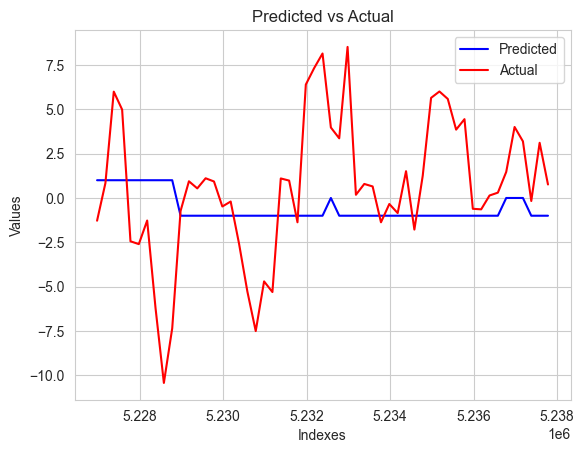

In [56]:
Y_pred = train['simple_prediction']
plt.plot(Y_pred, color='blue', label='Predicted')
plt.plot(train['target'], color='red', label='Actual')
plt.xlabel('Indexes')
plt.ylabel('Values')
plt.title('Predicted vs Actual')
plt.legend()
plt.show()

**Neural Network**

In [266]:
NN_data = pd.get_dummies(NN_data, columns=['imbalance_buy_sell_flag'])
NN_data.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,imbalance_buy_sell_flag_-1,imbalance_buy_sell_flag_0,imbalance_buy_sell_flag_1
0,0,0,0,3180602.69,0.999812,13380276.64,0.999919,0.999919,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,False,False,True
191,0,0,10,1299772.70,1.000026,15261106.63,0.999919,0.999919,0.999812,13996.50,1.000026,23519.16,0.999892,0.389814,False,False,True
382,0,0,20,1299772.70,0.999919,15261106.63,0.999866,0.999866,0.999812,4665.50,0.999919,12131.60,0.999842,4.220009,False,False,True
573,0,0,30,1299772.70,1.000133,15261106.63,1.000080,1.000080,1.000026,55998.00,1.000133,46203.30,1.000085,5.450249,False,False,True
764,0,0,40,1218204.43,1.000455,15342674.90,1.000348,1.000348,1.000241,14655.95,1.000455,26610.45,1.000317,3.169775,False,False,True


In [267]:
# X/y split
NN_X = NN_data.drop(columns = ['seconds_in_bucket'])

In [268]:
columns_to_normalize = ['imbalance_size', 'reference_price', 'matched_size', 'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price', 'ask_size', 'wap']

NN_scaler = StandardScaler()
NN_X = NN_X.copy()  # Make a copy to keep the original data unchanged

# Normalize only specified columns
NN_X[columns_to_normalize] = NN_scaler.fit_transform(NN_X[columns_to_normalize])
NN_X.head()

,stock_id,date_id,imbalance_size,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,imbalance_buy_sell_flag_-1,imbalance_buy_sell_flag_0,imbalance_buy_sell_flag_1
0,0,0,-0.123548,-0.072473,-0.226828,-0.001766,0.008710,0.034293,0.079314,-0.095017,-0.348522,0.003222,-3.029704,False,False,True
191,0,0,-0.215224,0.012028,-0.213379,-0.001766,0.008710,0.034293,-0.339406,-0.095017,-0.232363,-0.040021,0.389814,False,False,True
382,0,0,-0.215224,-0.030223,-0.213379,-0.001877,0.002282,0.034293,-0.423150,-0.137646,-0.320394,-0.060041,4.220009,False,False,True
573,0,0,-0.215224,0.054279,-0.213379,-0.001433,0.027996,0.119915,0.037549,-0.052388,-0.057003,0.037256,5.450249,False,False,True
764,0,0,-0.219200,0.181426,-0.212795,-0.000877,0.060258,0.205938,-0.333488,0.075896,-0.208465,0.130149,3.169775,False,False,True


In [269]:
NN_X = pd.get_dummies(NN_X, columns=['stock_id'])
NN_X.head()

,date_id,imbalance_size,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,...,stock_id_190,stock_id_191,stock_id_192,stock_id_193,stock_id_194,stock_id_195,stock_id_196,stock_id_197,stock_id_198,stock_id_199
0,0,-0.123548,-0.072473,-0.226828,-0.001766,0.008710,0.034293,0.079314,-0.095017,-0.348522,...,False,False,False,False,False,False,False,False,False,False
191,0,-0.215224,0.012028,-0.213379,-0.001766,0.008710,0.034293,-0.339406,-0.095017,-0.232363,...,False,False,False,False,False,False,False,False,False,False
382,0,-0.215224,-0.030223,-0.213379,-0.001877,0.002282,0.034293,-0.423150,-0.137646,-0.320394,...,False,False,False,False,False,False,False,False,False,False
573,0,-0.215224,0.054279,-0.213379,-0.001433,0.027996,0.119915,0.037549,-0.052388,-0.057003,...,False,False,False,False,False,False,False,False,False,False
764,0,-0.219200,0.181426,-0.212795,-0.000877,0.060258,0.205938,-0.333488,0.075896,-0.208465,...,False,False,False,False,False,False,False,False,False,False


In [270]:
def make_batches_simple(data, num_dates):
    batches = []
    for date_id in tqdm(range(num_dates - 1), desc="Creating Batches"):
        batch_data = data[(data['date_id'] == date_id)]
        batch_data = batch_data.drop(columns = ['date_id'])
        if len(batch_data) == 11000:
            batches.append(batch_data)
    print("DONE")
    return batches

In [271]:
def make_testing_sets(data, num_dates):
    testing_data = data[(data['date_id'] == num_dates - 1)]
    testing_data = testing_data.drop(columns = ['date_id'])
    ploting_data = testing_data[(testing_data['stock_id_0'] == True)]
    return testing_data, ploting_data

In [272]:
NN_train = make_batches_simple(NN_X, num_dates)

Creating Batches: 100%|██████████| 480/480 [00:05<00:00, 90.79it/s]


DONE


In [273]:
NN_test, NN_plot = make_testing_sets(NN_X, num_dates)

In [274]:
test_labels = NN_test['target']
test_features = NN_test.drop(columns=['target'])
test_labels = test_labels.astype('float32')
test_features = test_features.astype('float32')
print(test_labels.shape, test_features.shape)

(11000,) (11000, 213)


In [275]:
# NN model
NN_model = Sequential()
NN_model.add(Dense(1024, activation='relu'))
NN_model.add(Dropout(0.2))
NN_model.add(Dense(512, activation='relu'))
NN_model.add(Dropout(0.2))
NN_model.add(Dense(256, activation='relu'))
NN_model.add(Dense(32, activation='relu'))
NN_model.add(Dropout(0.2))
NN_model.add(Dense(4, activation='relu'))
NN_model.add(Dense(1, activation='linear'))
NN_model.compile(optimizer='adam', loss='mae',metrics=['accuracy'])

In [276]:
for epochs in range(10):
    for i in tqdm(range(len(NN_train))):
        batch = NN_train[i]
        labels = batch['target']
        features = batch.drop(columns=['target'])
        labels = labels.astype('float32')
        features = features.astype('float32')
        if i != len(NN_train) - 1:
            NN_model.fit(features, labels, verbose=0)
        else:
            NN_model.fit(features, labels, validation_data=(test_features, test_labels))

 99%|█████████▉| 180/181 [02:22<00:00,  1.29it/s]

344/344 [==============================] - 1s 4ms/step - loss: 5.6425 - accuracy: 5.4545e-04 - val_loss: 4.8595 - val_accuracy: 6.3636e-04


 99%|█████████▉| 180/181 [02:20<00:00,  1.25it/s]

344/344 [==============================] - 1s 3ms/step - loss: 5.6380 - accuracy: 5.4545e-04 - val_loss: 4.8544 - val_accuracy: 5.4545e-04


 99%|█████████▉| 180/181 [02:20<00:00,  1.27it/s]

344/344 [==============================] - 1s 3ms/step - loss: 5.6492 - accuracy: 5.4545e-04 - val_loss: 4.8583 - val_accuracy: 7.2727e-04


 99%|█████████▉| 180/181 [02:21<00:00,  1.23it/s]

344/344 [==============================] - 1s 3ms/step - loss: 5.6284 - accuracy: 5.4545e-04 - val_loss: 4.8669 - val_accuracy: 7.2727e-04


 99%|█████████▉| 180/181 [02:20<00:00,  1.30it/s]

344/344 [==============================] - 1s 3ms/step - loss: 5.6590 - accuracy: 3.6364e-04 - val_loss: 4.8711 - val_accuracy: 6.3636e-04


 99%|█████████▉| 180/181 [02:20<00:00,  1.30it/s]

344/344 [==============================] - 1s 3ms/step - loss: 5.6544 - accuracy: 5.4545e-04 - val_loss: 4.8721 - val_accuracy: 6.3636e-04


 99%|█████████▉| 180/181 [02:21<00:00,  1.28it/s]

344/344 [==============================] - 1s 3ms/step - loss: 5.6589 - accuracy: 3.6364e-04 - val_loss: 4.8561 - val_accuracy: 7.2727e-04


 99%|█████████▉| 180/181 [02:18<00:00,  1.31it/s]

344/344 [==============================] - 1s 3ms/step - loss: 5.6575 - accuracy: 5.4545e-04 - val_loss: 4.8679 - val_accuracy: 5.4545e-04


 99%|█████████▉| 180/181 [02:19<00:00,  1.31it/s]

344/344 [==============================] - 1s 3ms/step - loss: 5.6548 - accuracy: 4.5455e-04 - val_loss: 4.9242 - val_accuracy: 7.2727e-04


 99%|█████████▉| 180/181 [02:18<00:00,  1.31it/s]

344/344 [==============================] - 1s 3ms/step - loss: 5.6563 - accuracy: 6.3636e-04 - val_loss: 4.8766 - val_accuracy: 6.3636e-04


100%|██████████| 181/181 [02:19<00:00,  1.29it/s]


In [277]:
NN_model.save("../models/NN_model.keras")

In [278]:
NN_ploting_data_y = NN_plot['target']
NN_ploting_data_X = NN_plot.drop(columns=['target'])

In [279]:
NN_ploting_data_X = NN_ploting_data_X.astype('float32')
NN_ploting_data_y = NN_ploting_data_y.astype('float32')
NN_ploting_data_X = np.array(NN_ploting_data_X)
NN_ploting_data_y = np.array(NN_ploting_data_y)

2/2 [==============================] - 0s 2ms/step
[ -1.2797117    0.8404255    5.990267     4.980564    -2.4402142
  -2.5999546   -1.270175    -6.200075   -10.420084    -7.339716
  -0.7301569    0.9405613    0.5400181    1.1098385    0.92983246
  -0.4798174   -0.2002716   -2.5701523   -5.2702427   -7.5000525
  -4.6998262   -5.300045     1.1003017    0.97990036  -1.3697147
   6.389618     7.3194504    8.13961      3.9696693    3.3605099
   8.510351     0.18000603   0.7903576    0.6496906   -1.3697147
  -0.33974648  -0.84996223   1.5103817   -1.7797947    1.2505054
   5.6397915    5.9998035    5.580187     3.85046      4.440546
  -0.6097555   -0.6401539    0.13947487   0.3004074    1.4698505
   3.9994717    3.1900406   -0.16987324   3.1101704    0.76055527]


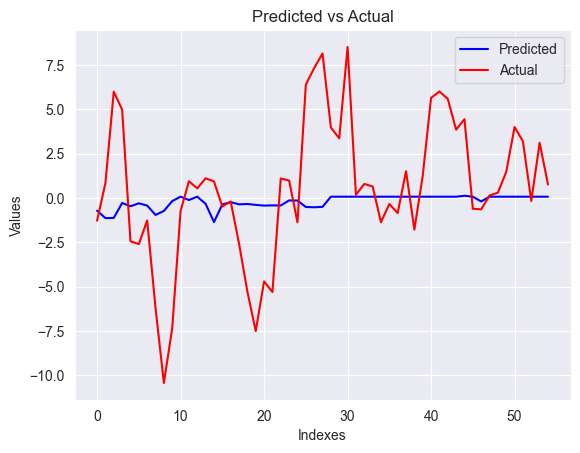

In [321]:
plot_target_graph(NN_model, NN_ploting_data_X, NN_ploting_data_y)

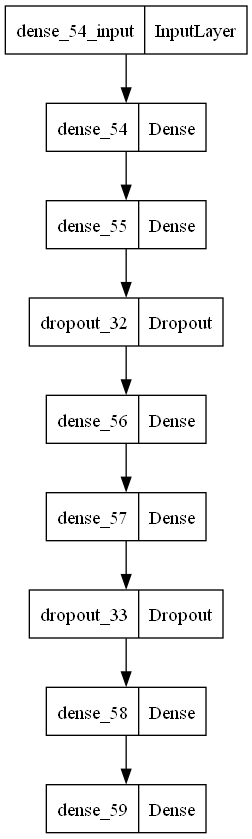

In [329]:
plot_model(NN_model)

**RNN all in one**


In [281]:
RNN_X = RNN_data.drop(columns=['seconds_in_bucket'])

In [282]:

columns_to_normalize = ['imbalance_size', 'reference_price', 'matched_size', 'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price', 'ask_size', 'wap']

RNN_scaler = StandardScaler()
RNN_X = RNN_X.copy()  # Make a copy to keep the original data unchanged

# Normalize only specified columns
RNN_X[columns_to_normalize] = RNN_scaler.fit_transform(RNN_X[columns_to_normalize])
RNN_X.head()

,stock_id,date_id,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target
0,0,0,-0.123548,1,-0.072473,-0.226828,-0.001766,0.008710,0.034293,0.079314,-0.095017,-0.348522,0.003222,-3.029704
191,0,0,-0.215224,1,0.012028,-0.213379,-0.001766,0.008710,0.034293,-0.339406,-0.095017,-0.232363,-0.040021,0.389814
382,0,0,-0.215224,1,-0.030223,-0.213379,-0.001877,0.002282,0.034293,-0.423150,-0.137646,-0.320394,-0.060041,4.220009
573,0,0,-0.215224,1,0.054279,-0.213379,-0.001433,0.027996,0.119915,0.037549,-0.052388,-0.057003,0.037256,5.450249
764,0,0,-0.219200,1,0.181426,-0.212795,-0.000877,0.060258,0.205938,-0.333488,0.075896,-0.208465,0.130149,3.169775


In [283]:
RNN_train=make_batches_simple(RNN_X, num_dates)

Creating Batches: 100%|██████████| 480/480 [00:02<00:00, 202.13it/s]

DONE


In [284]:
def make_rnn_testing_sets(data, num_dates):
    testing_data = data[(data['date_id'] == num_dates - 1)]
    testing_data = testing_data.drop(columns = ['date_id'])
    ploting_data = testing_data[(testing_data['stock_id'] == 0)]
    return testing_data, ploting_data

In [285]:
RNN_test, RNN_plot = make_rnn_testing_sets(RNN_X, num_dates)

In [286]:
one_model_to_rule_them_all = Sequential()
one_model_to_rule_them_all.add(LSTM(units=200, activation='relu'))
one_model_to_rule_them_all.add(Dense(units=100))
one_model_to_rule_them_all.add(Dropout(0.3))
one_model_to_rule_them_all.add(Dense(units=10))
one_model_to_rule_them_all.add(Dropout(0.3))
one_model_to_rule_them_all.add(Dense(units=1))
one_model_to_rule_them_all.compile(optimizer='adam', loss='mae')

In [287]:
sequence_length = 6
epochs = 10
for _ in tqdm(range(epochs)):
    for batch in RNN_train:
        batch = np.array(batch)
        inputs = []
        outputs = []
        for i in range(batch.shape[0] - sequence_length):
            inputs.append(batch[i:i+sequence_length])
            outputs.append(batch[i + sequence_length][-1])
        inputs = np.array(inputs)
        outputs = np.array(outputs)
        outputs = outputs.astype('float32')
        inputs = inputs.astype('float32')
        one_model_to_rule_them_all.fit(inputs, outputs, verbose=0)

100%|██████████| 10/10 [34:12<00:00, 205.28s/it]


In [288]:
inputs = []
outputs = []
for i in range(RNN_test.shape[0] - sequence_length):
    batch = np.array(RNN_test)
    inputs.append(batch[i:i+sequence_length])
    outputs.append(batch[i + sequence_length][-1])
inputs = np.array(inputs)
outputs = np.array(outputs)
outputs = outputs.astype('float32')
inputs = inputs.astype('float32')
loss =  one_model_to_rule_them_all.evaluate(inputs, outputs)
print("LOSS FOR RNN:", loss)

344/344 [==============================] - 1s 2ms/step - loss: 2.5826
LOSS FOR RNN: 2.5825793743133545


2/2 [==============================] - 0s 3ms/step
[ -1.270175    -6.200075   -10.420084    -7.339716    -0.7301569
   0.9405613    0.5400181    1.1098385    0.92983246  -0.4798174
  -0.2002716   -2.5701523   -5.2702427   -7.5000525   -4.6998262
  -5.300045     1.1003017    0.97990036  -1.3697147    6.389618
   7.3194504    8.13961      3.9696693    3.3605099    8.510351
   0.18000603   0.7903576    0.6496906   -1.3697147   -0.33974648
  -0.84996223   1.5103817   -1.7797947    1.2505054    5.6397915
   5.9998035    5.580187     3.85046      4.440546    -0.6097555
  -0.6401539    0.13947487   0.3004074    1.4698505    3.9994717
   3.1900406   -0.16987324   3.1101704    0.76055527]


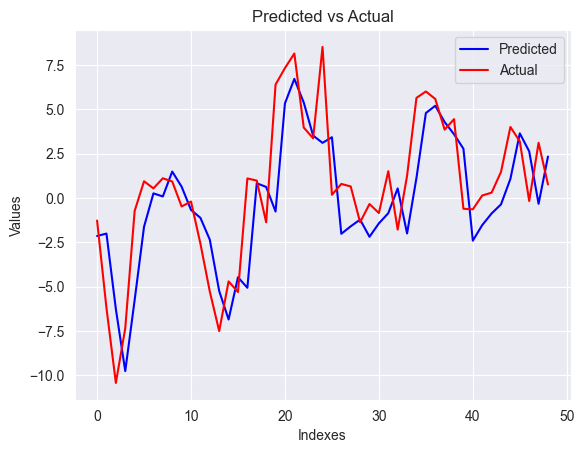

In [322]:
inputs = []
outputs = []
for i in range(RNN_plot.shape[0] - sequence_length):
    batch = np.array(RNN_plot)
    inputs.append(batch[i:i+sequence_length])
    outputs.append(batch[i + sequence_length][-1])
inputs = np.array(inputs)
outputs = np.array(outputs)
outputs = outputs.astype('float32')
inputs = inputs.astype('float32')
plot_target_graph(one_model_to_rule_them_all, inputs, outputs)

In [290]:
one_model_to_rule_them_all.save("../models/one_model_to_rule_them_all")

INFO:tensorflow:Assets written to: ../models/one_model_to_rule_them_all\assets


INFO:tensorflow:Assets written to: ../models/one_model_to_rule_them_all\assets


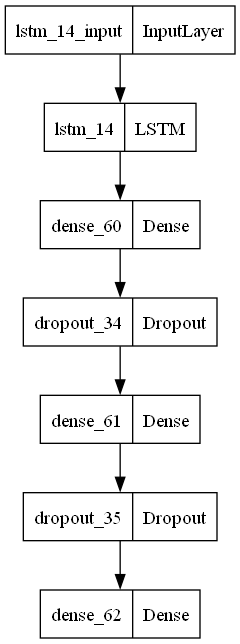

In [328]:
plot_model(one_model_to_rule_them_all)

**FRNN**

In [291]:
FRNN_data.head()


,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target
0,0,0,0,3180602.69,1,0.999812,13380276.64,0.999919,0.999919,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704
191,0,0,10,1299772.70,1,1.000026,15261106.63,0.999919,0.999919,0.999812,13996.50,1.000026,23519.16,0.999892,0.389814
382,0,0,20,1299772.70,1,0.999919,15261106.63,0.999866,0.999866,0.999812,4665.50,0.999919,12131.60,0.999842,4.220009
573,0,0,30,1299772.70,1,1.000133,15261106.63,1.000080,1.000080,1.000026,55998.00,1.000133,46203.30,1.000085,5.450249
764,0,0,40,1218204.43,1,1.000455,15342674.90,1.000348,1.000348,1.000241,14655.95,1.000455,26610.45,1.000317,3.169775


In [292]:
FRNN_X = FRNN_data.drop(columns=['seconds_in_bucket'])
FRNN_X = FRNN_X[FRNN_X['stock_id'] == 0]

In [293]:
FRNN_X = FRNN_X.drop(columns=['stock_id'])

In [294]:

columns_to_normalize = ['imbalance_size', 'reference_price', 'matched_size', 'far_price', 'near_price', 'bid_price',
                        'bid_size', 'ask_price', 'ask_size', 'wap']

FRNN_scaler = StandardScaler()
FRNN_X = FRNN_X.copy()  # Make a copy to keep the original data unchanged

# Normalize only specified columns
FRNN_X[columns_to_normalize] = FRNN_scaler.fit_transform(FRNN_X[columns_to_normalize])
FRNN_X.head()


,date_id,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target
0,0,-0.123790,1,-0.013518,-0.587920,0.119968,0.128397,0.045703,0.326694,0.042625,-0.517854,0.094031,-3.029704
191,0,-0.349821,1,0.113975,-0.498562,0.119968,0.128397,0.045703,-0.292755,0.042625,-0.257289,0.029652,0.389814
382,0,-0.349821,1,0.050229,-0.498562,0.115375,0.122531,0.045703,-0.416645,-0.021117,-0.454758,-0.000153,4.220009
573,0,-0.349821,1,0.177722,-0.498562,0.133746,0.145994,0.173498,0.264908,0.106367,0.136072,0.144700,5.450249
764,0,-0.359623,1,0.369557,-0.494687,0.156796,0.175432,0.301890,-0.284000,0.298188,-0.203683,0.282996,3.169775


In [295]:
def make_frnn_testing_sets(data, num_dates):
    testing_data = data[(data['date_id'] == num_dates - 1)]
    testing_data = testing_data.drop(columns=['date_id'])
    ploting_data = testing_data
    return testing_data, ploting_data


FRNN_test, FRNN_plot = make_frnn_testing_sets(FRNN_X, num_dates)

In [296]:
FRNN_X = FRNN_X.drop(columns=['date_id']);

In [297]:
frnn_model = Sequential()
frnn_model.add(LSTM(units=200, activation='relu'))
frnn_model.add(Dense(units=100))
frnn_model.add(Dropout(0.3))
frnn_model.add(Dense(units=10))
frnn_model.add(Dropout(0.3))
frnn_model.add(Dense(units=1))
frnn_model.compile(optimizer='adam', loss='mae')

In [298]:
sequence_length = 6
epochs = 10
for _ in tqdm(range(epochs)):
    batch = np.array(FRNN_X)
    inputs = []
    outputs = []
    for i in range(batch.shape[0] - sequence_length):
        inputs.append(batch[i:i+sequence_length])
        outputs.append(batch[i + sequence_length][-1])
    inputs = np.array(inputs)
    outputs = np.array(outputs)
    outputs = outputs.astype('float32')
    inputs = inputs.astype('float32')
    frnn_model.fit(inputs, outputs, verbose=0)

100%|██████████| 10/10 [00:30<00:00,  3.05s/it]


In [299]:
inputs = []
outputs = []
for i in range(FRNN_test.shape[0] - sequence_length):
    batch = np.array(FRNN_test)
    inputs.append(batch[i:i+sequence_length])
    outputs.append(batch[i + sequence_length][-1])
inputs = np.array(inputs)
outputs = np.array(outputs)
outputs = outputs.astype('float32')
inputs = inputs.astype('float32')
loss =  frnn_model.evaluate(inputs, outputs)
hello = frnn_model.predict(inputs)
print(hello)
print(outputs)
print("LOSS FOR FRNN:", loss)

2/2 [==============================] - 0s 2ms/step
[[-2.0524378 ]
 [-1.7665521 ]
 [-5.6169763 ]
 [-8.659245  ]
 [-5.633061  ]
 [-0.95029056]
 [ 0.73055196]
 [ 0.4987665 ]
 [ 1.5540481 ]
 [ 1.1492239 ]
 [-0.86583793]
 [-0.5611436 ]
 [-2.0814412 ]
 [-4.3545537 ]
 [-6.170681  ]
 [-3.8817317 ]
 [-3.9673035 ]
 [ 0.5164567 ]
 [ 0.9781755 ]
 [-0.37841296]
 [ 4.769801  ]
 [ 5.9962893 ]
 [ 5.580103  ]
 [ 2.3079746 ]
 [ 2.3363917 ]
 [ 3.9105186 ]
 [-0.7450627 ]
 [-0.29990742]
 [-0.05728467]
 [-1.4736402 ]
 [-0.81741315]
 [-0.3931114 ]
 [ 0.66758454]
 [-1.1985333 ]
 [ 0.5766932 ]
 [ 3.7391698 ]
 [ 4.46857   ]
 [ 3.4555252 ]
 [ 2.6034107 ]
 [ 2.0665245 ]
 [-1.4899664 ]
 [-1.4495838 ]
 [-0.8528623 ]
 [-0.1945375 ]
 [ 0.28765061]
 [ 3.0495317 ]
 [ 1.892044  ]
 [ 0.09398208]
 [ 1.5198778 ]]
[ -1.270175    -6.200075   -10.420084    -7.339716    -0.7301569
   0.9405613    0.5400181    1.1098385    0.92983246  -0.4798174
  -0.2002716   -2.5701523   -5.2702427   -7.5000525   -4.6998262
  -5.300045     1.

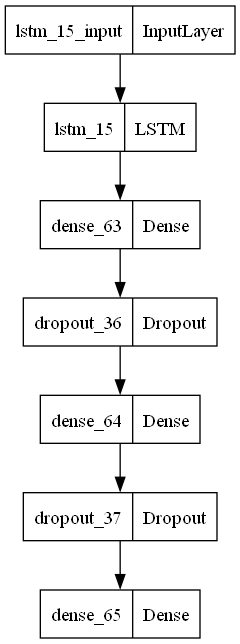

In [327]:
plot_model(frnn_model)

2/2 [==============================] - 0s 3ms/step
[ -1.270175    -6.200075   -10.420084    -7.339716    -0.7301569
   0.9405613    0.5400181    1.1098385    0.92983246  -0.4798174
  -0.2002716   -2.5701523   -5.2702427   -7.5000525   -4.6998262
  -5.300045     1.1003017    0.97990036  -1.3697147    6.389618
   7.3194504    8.13961      3.9696693    3.3605099    8.510351
   0.18000603   0.7903576    0.6496906   -1.3697147   -0.33974648
  -0.84996223   1.5103817   -1.7797947    1.2505054    5.6397915
   5.9998035    5.580187     3.85046      4.440546    -0.6097555
  -0.6401539    0.13947487   0.3004074    1.4698505    3.9994717
   3.1900406   -0.16987324   3.1101704    0.76055527]


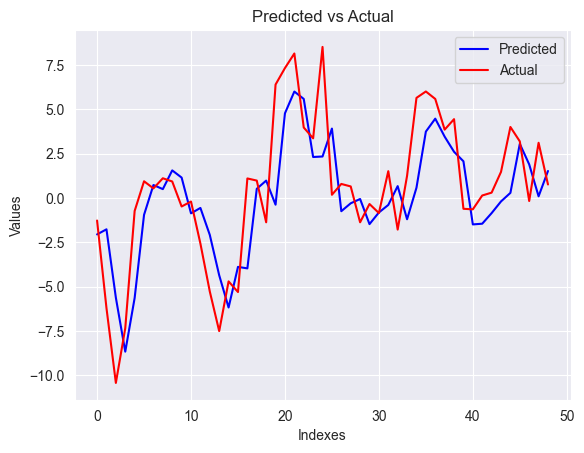

In [323]:
inputs = []
outputs = []
for i in range(FRNN_plot.shape[0] - sequence_length):
    batch = np.array(FRNN_plot)
    inputs.append(batch[i:i+sequence_length])
    outputs.append(batch[i + sequence_length][-1])
inputs = np.array(inputs)
outputs = np.array(outputs)
outputs = outputs.astype('float32')
inputs = inputs.astype('float32')
plot_target_graph(frnn_model, inputs, outputs)

**CONV #little FE**


In [301]:
CNN2_data.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target
0,0,0,0,3180602.69,1,0.999812,13380276.64,0.999919,0.999919,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704
191,0,0,10,1299772.70,1,1.000026,15261106.63,0.999919,0.999919,0.999812,13996.50,1.000026,23519.16,0.999892,0.389814
382,0,0,20,1299772.70,1,0.999919,15261106.63,0.999866,0.999866,0.999812,4665.50,0.999919,12131.60,0.999842,4.220009
573,0,0,30,1299772.70,1,1.000133,15261106.63,1.000080,1.000080,1.000026,55998.00,1.000133,46203.30,1.000085,5.450249
764,0,0,40,1218204.43,1,1.000455,15342674.90,1.000348,1.000348,1.000241,14655.95,1.000455,26610.45,1.000317,3.169775


In [302]:
def split_by_date(df, dates):

    df_start, df_end = dates
    df = df[(df['date_id'] >= df_start) & (df['date_id'] <=df_end)].reset_index(drop=True)

    return df

In [303]:
from itertools import combinations

# dodati nove imblanace kolone
def compute_imbalances(df_, columns, prefix = ''):
    df = df_.copy()
    for col1, col2 in combinations(columns, 2):
        col1, col2 = sorted([col1, col2])
        total = df[col1] + df[col2]
        imbalance_column_name = f'{col1}_{col2}_imb{prefix}'
        # Ensure we don't divide by zero
        df[imbalance_column_name] = (df[col1] - df[col2]).divide(total, fill_value=np.nan)
    return df

def compute_divisions(df_,columns):
    df = df_.copy()
    for col1, col2 in combinations(columns, 2):
        imbalance_column_name = f'{col1}/{col2}'
        # Ensure we don't divide by zero
        df[imbalance_column_name] = (df[col1]).divide(df[col2], fill_value=np.nan)
    return df

In [304]:
columns_prices    = ['reference_price','far_price','near_price','bid_price','ask_price','wap']
columns_sizes     = ['imbalance_size','matched_size','bid_size','ask_size']
lags = 3

#Kombinujemo velicine sa velicinama i cijene sa cijenama
CNN2_data = compute_imbalances(CNN2_data, columns_sizes,prefix='_sz_')
CNN2_data = compute_imbalances(CNN2_data, columns_prices,prefix = '_pr_')
CNN2_data.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,...,far_price_near_price_imb_pr_,bid_price_far_price_imb_pr_,ask_price_far_price_imb_pr_,far_price_wap_imb_pr_,bid_price_near_price_imb_pr_,ask_price_near_price_imb_pr_,near_price_wap_imb_pr_,ask_price_bid_price_imb_pr_,bid_price_wap_imb_pr_,ask_price_wap_imb_pr_
0,0,0,0,3180602.69,1,0.999812,13380276.64,0.999919,0.999919,0.999812,...,0.0,-0.000054,0.000054,-0.000041,-0.000054,0.000054,-0.000041,0.000107,-0.000094,0.000013
191,0,0,10,1299772.70,1,1.000026,15261106.63,0.999919,0.999919,0.999812,...,0.0,-0.000054,0.000054,0.000014,-0.000054,0.000054,0.000014,0.000107,-0.000040,0.000067
382,0,0,20,1299772.70,1,0.999919,15261106.63,0.999866,0.999866,0.999812,...,0.0,-0.000027,0.000027,0.000012,-0.000027,0.000027,0.000012,0.000054,-0.000015,0.000039
573,0,0,30,1299772.70,1,1.000133,15261106.63,1.000080,1.000080,1.000026,...,0.0,-0.000027,0.000027,-0.000003,-0.000027,0.000027,-0.000003,0.000053,-0.000029,0.000024
764,0,0,40,1218204.43,1,1.000455,15342674.90,1.000348,1.000348,1.000241,...,0.0,-0.000053,0.000053,0.000015,-0.000053,0.000053,0.000015,0.000107,-0.000038,0.000069


In [305]:
#Stavljamo target od jucer prekjucer i preknakjucer
def lag_function(df, columns_to_lag, numbers_of_days_to_lag):

    df_indexed = df.set_index(['stock_id', 'seconds_in_bucket', 'date_id'])

    for column_to_lag in columns_to_lag:
        for number_days_to_lag in numbers_of_days_to_lag:
            df_indexed[f'lag{number_days_to_lag}_{column_to_lag}'] = df_indexed.groupby(level=['stock_id', 'seconds_in_bucket'])[column_to_lag].shift(number_days_to_lag)

    df_indexed.reset_index(inplace=True)

    return df_indexed

In [306]:
CNN2_data = lag_function(CNN2_data,['target'], [lags])

In [307]:
features = [col for col in CNN2_data.columns if col not in ["stock_id", "date_id"]]
rnn_numerical_features = [feat for feat in features if feat != 'seconds_in_bucket']

In [308]:
CNN2_scaler = StandardScaler()
CNN2_data[rnn_numerical_features] = CNN2_scaler.fit_transform(CNN2_data[rnn_numerical_features])
CNN2_data.head()

,stock_id,seconds_in_bucket,date_id,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,...,bid_price_far_price_imb_pr_,ask_price_far_price_imb_pr_,far_price_wap_imb_pr_,bid_price_near_price_imb_pr_,ask_price_near_price_imb_pr_,near_price_wap_imb_pr_,ask_price_bid_price_imb_pr_,bid_price_wap_imb_pr_,ask_price_wap_imb_pr_,lag3_target
0,0,0,0,-0.123548,1.142927,-0.072473,-0.226828,-0.001766,0.008710,0.034293,...,-0.001308,-0.023491,0.006625,-0.002442,-0.045637,0.012803,-0.556010,0.212205,-0.661178,NaN
1,0,10,0,-0.215224,1.142927,0.012028,-0.213379,-0.001766,0.008710,0.034293,...,-0.001308,-0.023491,0.014017,-0.002442,-0.045637,0.027202,-0.556010,0.507221,-0.371455,NaN
2,0,20,0,-0.215224,1.142927,-0.030223,-0.213379,-0.001877,0.002282,0.034293,...,0.002352,-0.027152,0.013778,0.004680,-0.052765,0.026736,-0.739540,0.643813,-0.524347,NaN
3,0,30,0,-0.215224,1.142927,0.054279,-0.213379,-0.001433,0.027996,0.119915,...,0.002352,-0.027152,0.011793,0.004682,-0.052766,0.022869,-0.739579,0.564623,-0.602177,NaN
4,0,40,0,-0.219200,1.142927,0.181426,-0.212795,-0.000877,0.060258,0.205938,...,-0.001305,-0.023494,0.014290,-0.002436,-0.045643,0.027734,-0.556168,0.518237,-0.360883,NaN


In [309]:
CNN2_data['seconds_in_bucket'] = CNN2_data['seconds_in_bucket'] / 10
CNN2_data.head()

,stock_id,seconds_in_bucket,date_id,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,...,bid_price_far_price_imb_pr_,ask_price_far_price_imb_pr_,far_price_wap_imb_pr_,bid_price_near_price_imb_pr_,ask_price_near_price_imb_pr_,near_price_wap_imb_pr_,ask_price_bid_price_imb_pr_,bid_price_wap_imb_pr_,ask_price_wap_imb_pr_,lag3_target
0,0,0.0,0,-0.123548,1.142927,-0.072473,-0.226828,-0.001766,0.008710,0.034293,...,-0.001308,-0.023491,0.006625,-0.002442,-0.045637,0.012803,-0.556010,0.212205,-0.661178,NaN
1,0,1.0,0,-0.215224,1.142927,0.012028,-0.213379,-0.001766,0.008710,0.034293,...,-0.001308,-0.023491,0.014017,-0.002442,-0.045637,0.027202,-0.556010,0.507221,-0.371455,NaN
2,0,2.0,0,-0.215224,1.142927,-0.030223,-0.213379,-0.001877,0.002282,0.034293,...,0.002352,-0.027152,0.013778,0.004680,-0.052765,0.026736,-0.739540,0.643813,-0.524347,NaN
3,0,3.0,0,-0.215224,1.142927,0.054279,-0.213379,-0.001433,0.027996,0.119915,...,0.002352,-0.027152,0.011793,0.004682,-0.052766,0.022869,-0.739579,0.564623,-0.602177,NaN
4,0,4.0,0,-0.219200,1.142927,0.181426,-0.212795,-0.000877,0.060258,0.205938,...,-0.001305,-0.023494,0.014290,-0.002436,-0.045643,0.027734,-0.556168,0.518237,-0.360883,NaN


In [310]:
from keras.src.layers import BatchNormalization, Activation, Add, Concatenate


def apply_conv_layers(input_layer, kernel_sizes, filters=16, do_ratio=0.4):
    conv_outputs = []

    for kernel_size in kernel_sizes:
        conv_layer = Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', padding='same')(input_layer)
        conv_layer = BatchNormalization()(conv_layer)
        conv_layer = Dropout(do_ratio)(conv_layer)

        shortcut = conv_layer

        conv_layer = Conv1D(filters=filters, kernel_size=kernel_size, padding='same')(conv_layer)
        conv_layer = BatchNormalization()(conv_layer)
        conv_layer = Activation('relu')(conv_layer)

        # Add the output of the first Conv1D layer
        conv_layer = Add()([conv_layer, shortcut])
        conv_outputs.append(conv_layer)


    concatenated_conv = Concatenate(axis=-1)(conv_outputs)
    flattened_conv_output = Flatten()(concatenated_conv)

    return flattened_conv_output

In [340]:
from keras.src.activations import swish
from keras.src.optimizers import Adam
from keras.src.optimizers.schedules import ExponentialDecay
from keras.src.layers import ZeroPadding1D, Embedding, Reshape
lags = 3
input_layer = Input(shape=(lags, len(rnn_numerical_features) + 1), name="combined_input")

# Split the input into numerical and categorical parts
numerical_input = Lambda(lambda x: x[:, :, :-1], name="numerical_part")(input_layer)
categorical_input = Lambda(lambda x: x[:, :, -1:], name="categorical_part")(input_layer)

first_numerical = Lambda(lambda x: x[:, 0])(numerical_input)


# diffrentiate layers
def create_difference_layer(lag):
    return Lambda(lambda x: x[:, lag:, :] - x[:, :-lag, :], name=f"difference_layer_lag{lag}")

difference_layers = []
for lag in range(1, lags):
    diff_layer = create_difference_layer(lag)(numerical_input)
    padding = ZeroPadding1D(padding=(lag, 0))(diff_layer)  # Add padding to the beginning of the sequence
    difference_layers.append(padding)
combined_diff_layer = Concatenate(name="combined_difference_layer")(difference_layers)


# Embedding for categorical part
num_timeframes = 55
dimention = 10
embedding = Embedding(num_timeframes, dimention, input_length=lags)(categorical_input)
embedding = Reshape((lags, -1))(embedding)

first_embedding = Lambda(lambda x: x[:, 0])(embedding)

# Concatenate numerical input and embedding
# conv_input = concatenate([enhanced_numerical_input, embedding], axis=-1)

kernel_sizes = [2,3]

flattened_conv_output = apply_conv_layers(numerical_input, kernel_sizes)
flattened_conv_output_cat = apply_conv_layers(embedding, kernel_sizes)
flattened_conv_output_diff = apply_conv_layers(combined_diff_layer, kernel_sizes)


dense_output = Concatenate(axis=-1)([flattened_conv_output,flattened_conv_output_cat,flattened_conv_output_diff, Reshape((-1,))(combined_diff_layer),first_numerical,first_embedding])

dense_sizes = [512, 256, 128, 64, 32]
do_ratio = 0.5

def custom_activation(x):
    return (2 * swish(x)) - 2

for size in dense_sizes:
    dense_output = Dense(size, activation='swish')(dense_output)
    dense_output = BatchNormalization()(dense_output)
    dense_output = Dropout(do_ratio)(dense_output)

# Output layer
output = Dense(1, name='output_layer', activation=custom_activation)(dense_output)

# Learning rate schedule
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.7,
    staircase=True)

# Create and compile the model
CNN2_model = Model(inputs=input_layer, outputs=output)
optimizer = Adam(learning_rate=lr_schedule)

CNN2_model.compile(optimizer=optimizer, loss="mae")

In [341]:
CNN2_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 combined_input (InputLayer  [(None, 3, 14)]              0         []                            
 )                                                                                                
                                                                                                  
 numerical_part (Lambda)     (None, 3, 13)                0         ['combined_input[0][0]']      
                                                                                                  
 categorical_part (Lambda)   (None, 3, 1)                 0         ['combined_input[0][0]']      
                                                                                                  
 difference_layer_lag1 (Lam  (None, 2, 13)                0         ['numerical_part[0][0]']

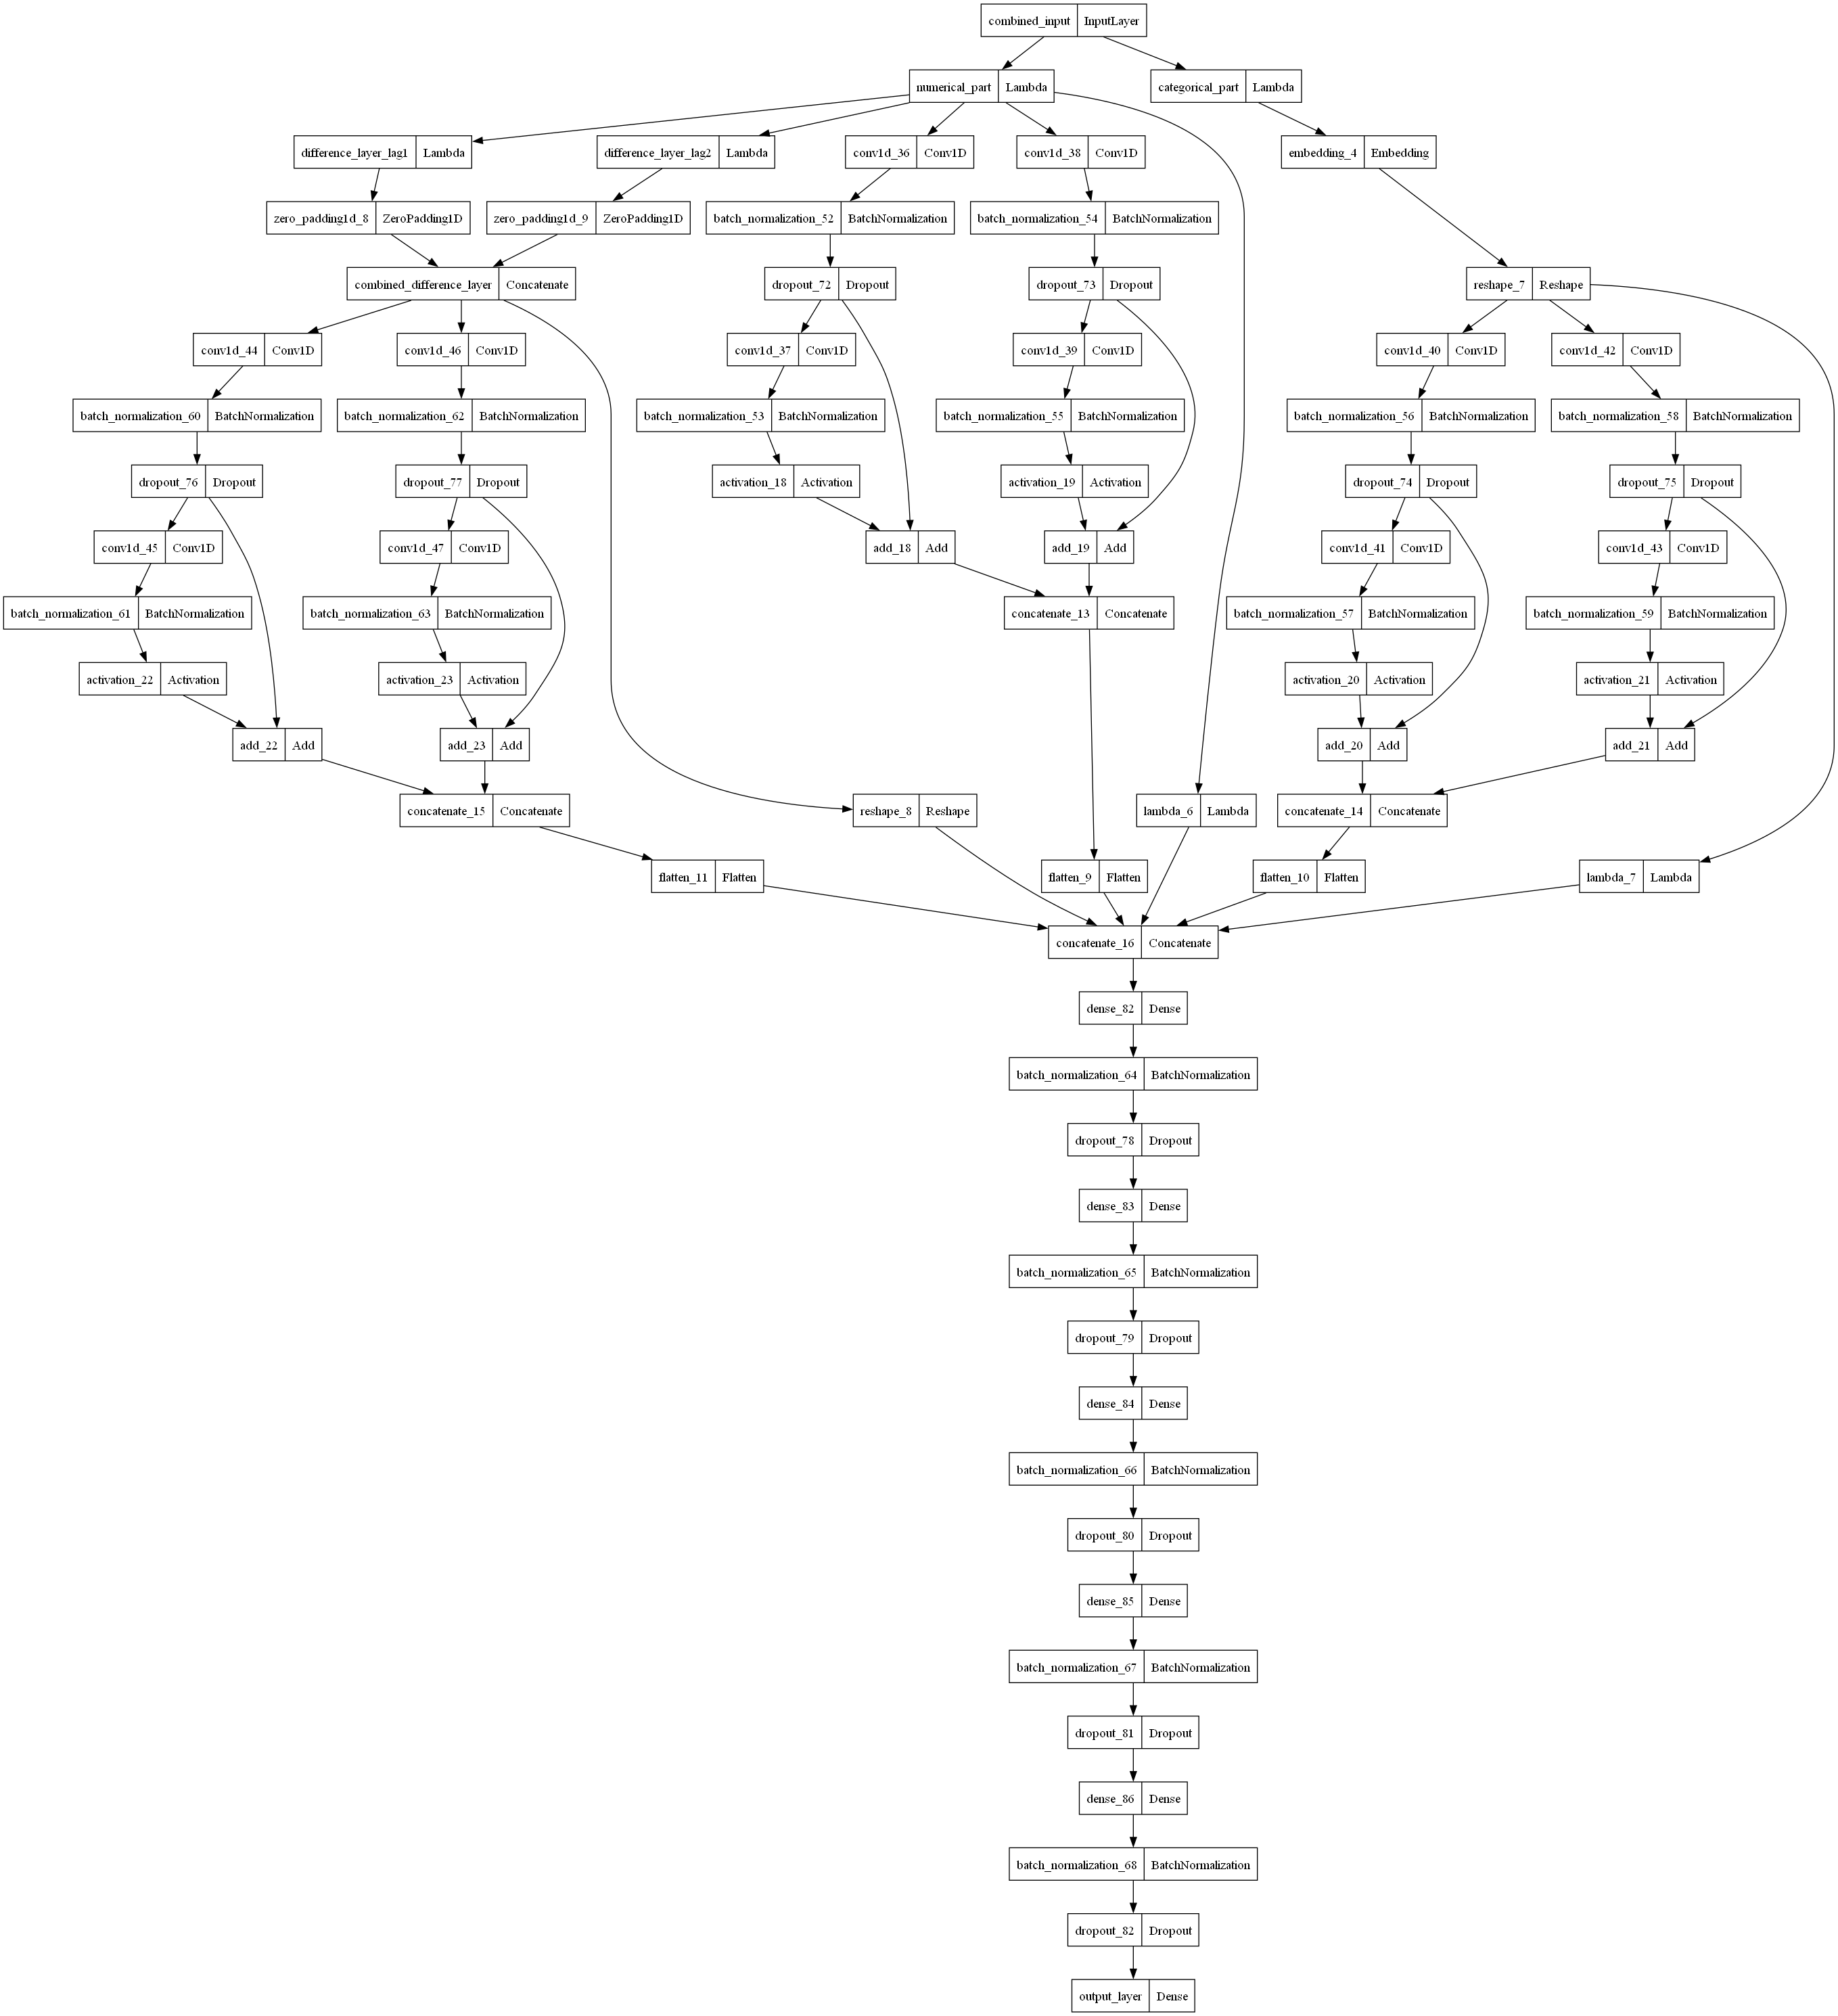

In [342]:
plot_model(CNN2_model)

In [343]:
CNN2_data = CNN2_data.fillna(0)
print(CNN2_data.isna().any())

stock_id                               False
seconds_in_bucket                      False
date_id                                False
imbalance_size                         False
imbalance_buy_sell_flag                False
reference_price                        False
matched_size                           False
far_price                              False
near_price                             False
bid_price                              False
bid_size                               False
ask_price                              False
ask_size                               False
wap                                    False
target                                 False
imbalance_size_matched_size_imb_sz_    False
bid_size_imbalance_size_imb_sz_        False
ask_size_imbalance_size_imb_sz_        False
bid_size_matched_size_imb_sz_          False
ask_size_matched_size_imb_sz_          False
ask_size_bid_size_imb_sz_              False
far_price_reference_price_imb_pr_      False
near_price

In [344]:
def make_batch(data):
    stock_data_num = data[rnn_numerical_features].values
    stock_data_cat = data[["seconds_in_bucket"]].values

    # Pre-compute all sequences
    all_sequences_num = [stock_data_num[max(0, i - lags + 1):i + 1] for i in range(len(data))]
    all_sequences_cat = [stock_data_cat[max(0, i - lags + 1):i + 1] for i in range(len(data))]

    # Add padding for first two sequences
    padded_sequences_num = [np.pad(seq, ((lags - len(seq), 0), (0, 0)), 'constant') for seq in all_sequences_num]
    padded_sequences_cat = [np.pad(seq, ((lags - len(seq), 0), (0, 0)), 'constant') for seq in all_sequences_cat]

    # Combine numerical and categorical features
    combined_sequences = np.array([np.concatenate([num, cat], axis=-1) for num, cat in zip(padded_sequences_num, padded_sequences_cat)])

    # Extract targets
    targets = data['target'].values
    return combined_sequences, targets

In [345]:
batches = []
for date_id in tqdm(range(num_dates - 1), desc="Creating Batches"):
    temp = CNN2_data[CNN2_data['date_id'] == date_id]
    batches.append(make_batch(temp))
print("DONE")

Creating Batches: 100%|██████████| 480/480 [02:22<00:00,  3.36it/s]

DONE


In [346]:
temp = CNN2_data[CNN2_data['date_id'] == num_dates - 1]
CNN2_testing = make_batch(temp)

In [347]:
temp = CNN2_data[(CNN2_data['date_id'] == num_dates - 1) & (CNN2_data['stock_id'] == 0)]
CNN2_ploting = make_batch(temp)

In [348]:
for epochs in tqdm(range(3)):
    for i in range(len(batches)):
        batch = batches[i]
        if i != len(batches) - 1:
            CNN2_model.fit(batch[0], batch[1], shuffle=False, verbose=0)
        else:
            CNN2_model.fit(batch[0], batch[1], shuffle=False, validation_data=(CNN2_testing[0], CNN2_testing[1]))
print("DONE")

  0%|          | 0/3 [00:00<?, ?it/s]

344/344 [==============================] - 3s 8ms/step - loss: 0.3207 - val_loss: 0.1407


 33%|███▎      | 1/3 [12:00<24:00, 720.16s/it]

344/344 [==============================] - 2s 7ms/step - loss: 0.3214 - val_loss: 0.1270


 67%|██████▋   | 2/3 [25:20<12:47, 767.07s/it]

344/344 [==============================] - 2s 7ms/step - loss: 0.3233 - val_loss: 0.1251


100%|██████████| 3/3 [38:36<00:00, 772.13s/it]

DONE


In [349]:
CNN2_model.save('../models/CNN2_model.keras')

2/2 [==============================] - 0s 4ms/step
[-0.13034454  0.09394179  0.63873625  0.53192119 -0.25311246 -0.27001117
 -0.12933566 -0.65086282 -1.09729161 -0.77142383 -0.07220791  0.10453501
  0.06216211  0.12244261  0.10340002 -0.04572485 -0.01615209 -0.26685842
 -0.55249718 -0.78838561 -0.49215362 -0.55564992  0.12143372  0.10869663
 -0.13986583  0.68098302  0.77934868  0.86611221  0.42498007  0.36053796
  0.90533237  0.02407694  0.08864517  0.07376421 -0.13986583 -0.03090694
 -0.08488195  0.16481551 -0.18324761  0.13732356  0.60165994  0.6397451
  0.59535446  0.41236908  0.47479345 -0.05947081 -0.06268662  0.01978921
  0.03681403  0.16052777  0.42813282  0.34250425 -0.01293629  0.33405489
  0.08549243]


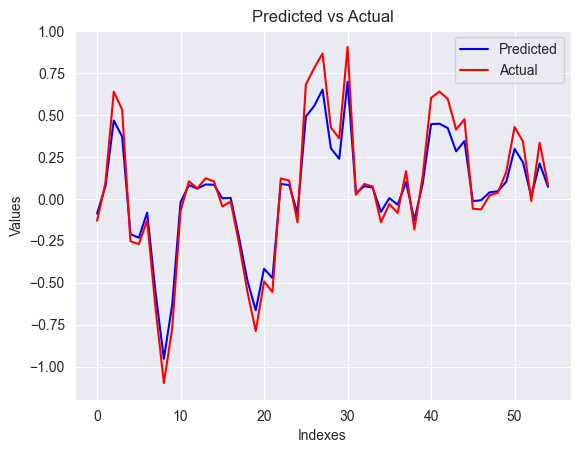

In [350]:
plot_target_graph(CNN2_model, CNN2_ploting[0], CNN2_ploting[1])

RNN

In [351]:
RNN2_data = lag_function(RNN2_data,['target'], [lags])
features = [col for col in RNN2_data.columns if col not in ["stock_id", "date_id"]]
rnn_numerical_features = [feat for feat in features if feat != 'seconds_in_bucket']
RNN2_scaler = StandardScaler()
RNN2_data[rnn_numerical_features] = RNN2_scaler.fit_transform(RNN2_data[rnn_numerical_features])
RNN2_data['seconds_in_bucket'] = RNN2_data['seconds_in_bucket'] / 10
RNN2_data.head()

,stock_id,seconds_in_bucket,date_id,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,lag3_target
0,0,0.0,0,-0.123548,1.142927,-0.072473,-0.226828,-0.001766,0.008710,0.034293,0.079314,-0.095017,-0.348522,0.003222,-0.315474,NaN
1,0,0.1,0,-0.215224,1.142927,0.012028,-0.213379,-0.001766,0.008710,0.034293,-0.339406,-0.095017,-0.232363,-0.040021,0.046272,NaN
2,0,0.2,0,-0.215224,1.142927,-0.030223,-0.213379,-0.001877,0.002282,0.034293,-0.423150,-0.137646,-0.320394,-0.060041,0.451463,NaN
3,0,0.3,0,-0.215224,1.142927,0.054279,-0.213379,-0.001433,0.027996,0.119915,0.037549,-0.052388,-0.057003,0.037256,0.581608,NaN
4,0,0.4,0,-0.219200,1.142927,0.181426,-0.212795,-0.000877,0.060258,0.205938,-0.333488,0.075896,-0.208465,0.130149,0.340360,NaN


In [352]:
RNN2_data = RNN2_data.fillna(0)
print(RNN2_data.isna().any())

stock_id                   False
seconds_in_bucket          False
date_id                    False
imbalance_size             False
imbalance_buy_sell_flag    False
reference_price            False
matched_size               False
far_price                  False
near_price                 False
bid_price                  False
bid_size                   False
ask_price                  False
ask_size                   False
wap                        False
target                     False
lag3_target                False
dtype: bool


In [353]:
from keras.src.layers import concatenate

window_size = 3
initial_learning_rate=0.001

input_layer = Input(shape=(window_size, len(rnn_numerical_features) + 1), name="combined_input")

# Split the input into numerical and categorical parts
numerical_input = Lambda(lambda x: x[:, :, :-1], name="numerical_part")(input_layer)
categorical_input = Lambda(lambda x: x[:, :, -1:], name="categorical_part")(input_layer)

# Function to create a difference layer for a given lag
def create_difference_layer(lag):
    return Lambda(lambda x: x[:, lag:,:] - x[:, :-lag, :], name=f"difference_layer_lag{lag}")

# List to store all difference layers
difference_layers = []

# Create difference layers for each lag
for lag in range(1, window_size):
    diff_layer = create_difference_layer(lag)(numerical_input)
    padding = ZeroPadding1D(padding=(lag, 0))(diff_layer)  # Add padding to the beginning of the sequence
    difference_layers.append(padding)



combined_diff_layer = Concatenate(name="combined_difference_layer")(difference_layers)

enhanced_numerical_input = Concatenate(name="enhanced_numerical_input")([numerical_input, combined_diff_layer])

#     concat_input = Concatenate(name="concatenated_input")([enhanced_numerical_input, categorical_input])

# Embedding for categorical part
vocab_size, embedding_dim = 55, 10 #broj razlicitih timeframe i velicina svakog timeframe
embedding = Embedding(vocab_size, embedding_dim, input_length=window_size)(categorical_input)
embedding = Reshape((window_size, -1))(embedding)



# Concatenate numerical input and embedding
lstm_input = concatenate([enhanced_numerical_input, embedding], axis=-1)

# Initialize a list to hold the outputs of each LSTM layer
#     lstm_outputs = []

# First LSTM layer
lstml = LSTM(64, return_sequences=False)(lstm_input)
lstml = BatchNormalization()(lstml)
lstml = Dropout(0.3)(lstml)

dense_output = lstml
dense_sizes = [512, 256, 128, 64, 32]
do_ratio = 0.3
for size in dense_sizes:
    dense_output = Dense(size, activation='swish')(dense_output)
    dense_output = BatchNormalization()(dense_output)
    dense_output = Dropout(do_ratio)(dense_output)

# Output layer
output = Dense(1, name='output_layer', activation=custom_activation)(dense_output)

# Learning rate schedule
lr_schedule = ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.7,
    staircase=True)

# Create and compile the model

RNN2_model = Model(inputs=input_layer, outputs=output)
optimizer = Adam(learning_rate=lr_schedule)

RNN2_model.compile(optimizer=optimizer, loss="mean_absolute_error")

In [354]:
RNN2_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 combined_input (InputLayer  [(None, 3, 14)]              0         []                            
 )                                                                                                
                                                                                                  
 numerical_part (Lambda)     (None, 3, 13)                0         ['combined_input[0][0]']      
                                                                                                  
 difference_layer_lag1 (Lam  (None, 2, 13)                0         ['numerical_part[0][0]']      
 bda)                                                                                             
                                                                                            

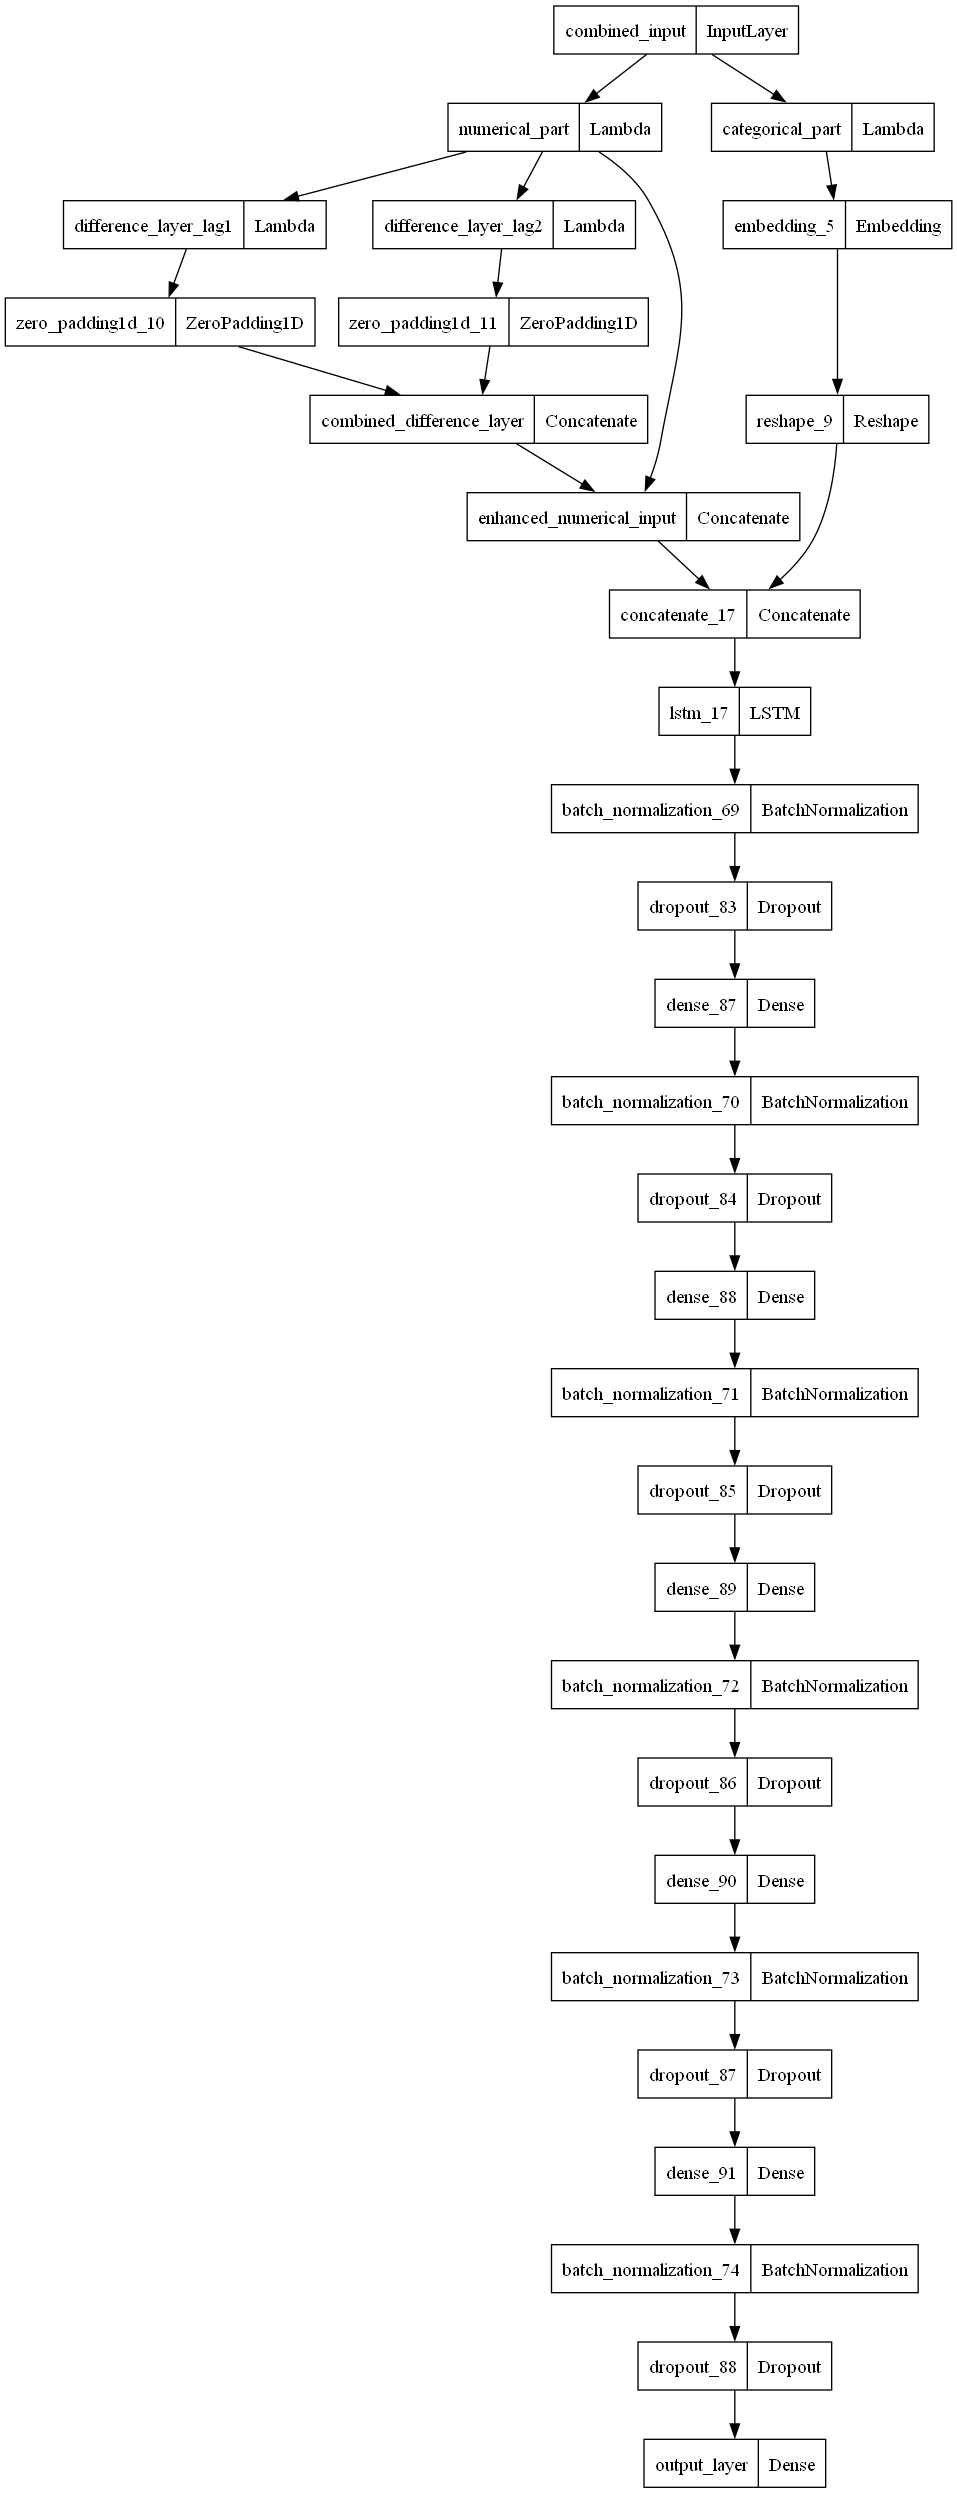

In [355]:
plot_model(RNN2_model)

In [356]:
batches = []
for date_id in tqdm(range(num_dates - 1), desc="Creating Batches"):
    temp = RNN2_data[RNN2_data['date_id'] == date_id]
    batches.append(make_batch(temp))
print("DONE")

Creating Batches: 100%|██████████| 480/480 [02:28<00:00,  3.23it/s]

DONE


In [357]:
temp = RNN2_data[RNN2_data['date_id'] == num_dates - 1]
RNN2_testing = make_batch(temp)

In [358]:
temp = RNN2_data[(RNN2_data['date_id'] == num_dates - 1) & (RNN2_data['stock_id'] == 0)]
RNN2_ploting = make_batch(temp)

In [359]:
for epochs in tqdm(range(5)):
    for i in range(len(batches)):
        batch = batches[i]
        if i != len(batches) - 1:
            RNN2_model.fit(batch[0], batch[1], shuffle=False, verbose=0)
        else:
            RNN2_model.fit(batch[0], batch[1], shuffle=False, validation_data=(RNN2_testing[0], RNN2_testing[1]))

100%|█████████▉| 479/480 [11:17<00:01,  1.26s/it]

344/344 [==============================] - 2s 6ms/step - loss: 0.2721 - val_loss: 0.1586


100%|█████████▉| 479/480 [10:30<00:01,  1.28s/it]

344/344 [==============================] - 2s 5ms/step - loss: 0.2740 - val_loss: 0.1503


100%|█████████▉| 479/480 [09:51<00:01,  1.25s/it]

344/344 [==============================] - 2s 5ms/step - loss: 0.2715 - val_loss: 0.1505


100%|█████████▉| 479/480 [09:46<00:01,  1.22s/it]

344/344 [==============================] - 2s 5ms/step - loss: 0.2724 - val_loss: 0.1511


100%|█████████▉| 479/480 [09:37<00:01,  1.21s/it]

344/344 [==============================] - 2s 5ms/step - loss: 0.2723 - val_loss: 0.1485


100%|██████████| 480/480 [09:39<00:00,  1.21s/it]


In [360]:
RNN2_model.save('../models/RNN2_model.keras')

2/2 [==============================] - 0s 3ms/step
[-0.13034454  0.09394179  0.63873625  0.53192119 -0.25311246 -0.27001117
 -0.12933566 -0.65086282 -1.09729161 -0.77142383 -0.07220791  0.10453501
  0.06216211  0.12244261  0.10340002 -0.04572485 -0.01615209 -0.26685842
 -0.55249718 -0.78838561 -0.49215362 -0.55564992  0.12143372  0.10869663
 -0.13986583  0.68098302  0.77934868  0.86611221  0.42498007  0.36053796
  0.90533237  0.02407694  0.08864517  0.07376421 -0.13986583 -0.03090694
 -0.08488195  0.16481551 -0.18324761  0.13732356  0.60165994  0.6397451
  0.59535446  0.41236908  0.47479345 -0.05947081 -0.06268662  0.01978921
  0.03681403  0.16052777  0.42813282  0.34250425 -0.01293629  0.33405489
  0.08549243]


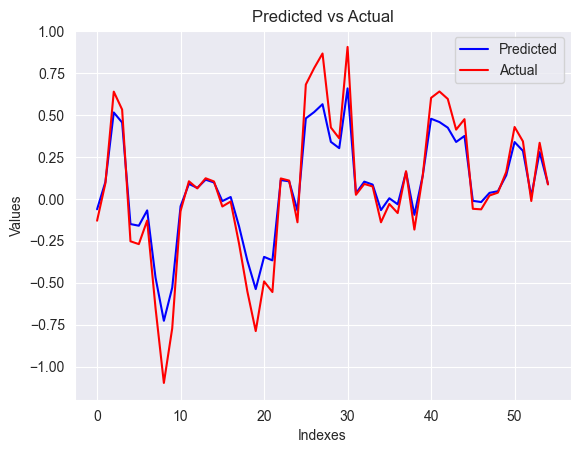

In [361]:
plot_target_graph(RNN2_model, RNN2_ploting[0], RNN2_ploting[1])

***BESTIE***

Heavy FE

In [362]:
def calculate_triplet_imbalance(df_,columns):
    df = df_.copy()
    for col1, col2, col3 in combinations(columns, 3):
        col1, col2, col3 = sorted([col1, col2, col3])
        imbalance_column_name = f"{col1}_{col2}_{col3}_imb3"
        total = df[col2] - df[col1]
        # Ensure we don't divide by zero
        df[imbalance_column_name] = (df[col3] - df[col2]).divide(total, fill_value=np.nan)

    return df

In [363]:
targets = BestNN_data['target']

In [364]:
num_updates = BestNN_data["seconds_in_bucket"].nunique()
print(f"# updates per day: {num_updates}")

stock_returns = np.zeros((num_stocks, num_dates, num_updates))
index_returns = np.zeros((num_stocks, num_dates, num_updates))

for (stock_id, date_id), frame in tqdm(data.groupby(["stock_id", "date_id"])):
    frame["stock_return"] = ((frame["wap"] / frame["wap"].shift(6)).shift(-6) - 1) * 10_000
    frame["index_return"] = frame["stock_return"] - frame["target"]

    stock_returns[stock_id, date_id] = frame["stock_return"].values
    index_returns[stock_id, date_id] = frame["index_return"].values

index_return = np.mean(index_returns, axis=0)

# updates per day: 55


100%|██████████| 95236/95236 [00:33<00:00, 2834.88it/s]


In [365]:


lr = LinearRegression()

# reshape .T je transponovano
y = index_return.reshape(-1)
X = stock_returns.reshape((num_stocks, -1)).T

#rijesit se NAN
mask = ~((np.isnan(y) | np.isnan(X).any(axis=1)))
X, y = X[mask], y[mask]

lr.fit(X, y)

# round to 3 and print weights
lr.coef_ = lr.coef_.round(3)
lr.intercept_ = 0.0
print(" Round with 3 digits ".center(80, ">"))
print("Coef:", lr.coef_)
print("Sum of Coef:", lr.coef_.sum())
print("R2:", r2_score(y, lr.predict(X)))

>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Round with 3 digits >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Coef: [0.004 0.001 0.002 0.006 0.004 0.004 0.002 0.006 0.006 0.002 0.002 0.008
 0.006 0.002 0.008 0.006 0.002 0.006 0.004 0.002 0.004 0.001 0.006 0.004
 0.002 0.002 0.004 0.002 0.004 0.004 0.001 0.001 0.002 0.002 0.006 0.004
 0.004 0.004 0.006 0.002 0.002 0.04  0.002 0.002 0.004 0.04  0.002 0.001
 0.006 0.004 0.004 0.006 0.001 0.004 0.004 0.002 0.006 0.004 0.006 0.004
 0.006 0.004 0.002 0.001 0.002 0.004 0.002 0.008 0.004 0.004 0.002 0.004
 0.006 0.002 0.004 0.004 0.002 0.004 0.004 0.004 0.001 0.002 0.002 0.008
 0.02  0.004 0.006 0.002 0.02  0.002 0.002 0.006 0.004 0.002 0.001 0.02
 0.006 0.001 0.002 0.004 0.001 0.002 0.006 0.006 0.004 0.006 0.001 0.002
 0.004 0.006 0.006 0.001 0.04  0.006 0.002 0.004 0.002 0.002 0.006 0.002
 0.002 0.004 0.006 0.006 0.002 0.002 0.008 0.006 0.004 0.002 0.006 0.002
 0.004 0.006 0.002 0.004 0.001 0.004 0.002 0.004 0.008 0.006 0.008 0.002
 0.004 0.002 0.001 0.004 0.004 0.004 0

In [366]:
weights = lr.coef_
weights = {int(k):v for k,v in enumerate(weights)}
print(weights)

{0: 0.004, 1: 0.001, 2: 0.002, 3: 0.006, 4: 0.004, 5: 0.004, 6: 0.002, 7: 0.006, 8: 0.006, 9: 0.002, 10: 0.002, 11: 0.008, 12: 0.006, 13: 0.002, 14: 0.008, 15: 0.006, 16: 0.002, 17: 0.006, 18: 0.004, 19: 0.002, 20: 0.004, 21: 0.001, 22: 0.006, 23: 0.004, 24: 0.002, 25: 0.002, 26: 0.004, 27: 0.002, 28: 0.004, 29: 0.004, 30: 0.001, 31: 0.001, 32: 0.002, 33: 0.002, 34: 0.006, 35: 0.004, 36: 0.004, 37: 0.004, 38: 0.006, 39: 0.002, 40: 0.002, 41: 0.04, 42: 0.002, 43: 0.002, 44: 0.004, 45: 0.04, 46: 0.002, 47: 0.001, 48: 0.006, 49: 0.004, 50: 0.004, 51: 0.006, 52: 0.001, 53: 0.004, 54: 0.004, 55: 0.002, 56: 0.006, 57: 0.004, 58: 0.006, 59: 0.004, 60: 0.006, 61: 0.004, 62: 0.002, 63: 0.001, 64: 0.002, 65: 0.004, 66: 0.002, 67: 0.008, 68: 0.004, 69: 0.004, 70: 0.002, 71: 0.004, 72: 0.006, 73: 0.002, 74: 0.004, 75: 0.004, 76: 0.002, 77: 0.004, 78: 0.004, 79: 0.004, 80: 0.001, 81: 0.002, 82: 0.002, 83: 0.008, 84: 0.02, 85: 0.004, 86: 0.006, 87: 0.002, 88: 0.02, 89: 0.002, 90: 0.002, 91: 0.006, 9

In [367]:
BestNN_data.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target
0,0,0,0,3180602.69,1,0.999812,13380276.64,0.999919,0.999919,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704
191,0,0,10,1299772.70,1,1.000026,15261106.63,0.999919,0.999919,0.999812,13996.50,1.000026,23519.16,0.999892,0.389814
382,0,0,20,1299772.70,1,0.999919,15261106.63,0.999866,0.999866,0.999812,4665.50,0.999919,12131.60,0.999842,4.220009
573,0,0,30,1299772.70,1,1.000133,15261106.63,1.000080,1.000080,1.000026,55998.00,1.000133,46203.30,1.000085,5.450249
764,0,0,40,1218204.43,1,1.000455,15342674.90,1.000348,1.000348,1.000241,14655.95,1.000455,26610.45,1.000317,3.169775


In [368]:
BestNN_data.stock_id.map(weights)

0          0.004
191        0.004
382        0.004
573        0.004
764        0.004
           ...  
5237179    0.004
5237379    0.004
5237579    0.004
5237779    0.004
5237979    0.004
Name: stock_id, Length: 5237760, dtype: float64

In [369]:
stock_groups = BestNN_data.groupby(["date_id", "seconds_in_bucket"])
prices = ["reference_price", "far_price", "near_price", "ask_price", "bid_price", "wap"]
sizes = ["matched_size", "bid_size", "ask_size", "imbalance_size"]

In [370]:
BestNN_data["wwap"] = BestNN_data.stock_id.map(weights) * BestNN_data.wap
BestNN_data["iwap"] = stock_groups["wwap"].transform(lambda x: x.sum())
del BestNN_data["wwap"]

In [371]:
# Calculate various features using Pandas eval function
BestNN_data["volume"] = BestNN_data.eval("ask_size + bid_size")
BestNN_data["mid_price"] = BestNN_data.eval("(ask_price + bid_price) / 2")
BestNN_data["liquidity_imbalance"] = BestNN_data.eval("(bid_size-ask_size)/(bid_size+ask_size)")
BestNN_data["matched_imbalance"] = BestNN_data.eval("(imbalance_size-matched_size)/(matched_size+imbalance_size)")
BestNN_data["all_size"] = BestNN_data.eval("matched_size + imbalance_size") # add
BestNN_data["imbalance_size_for_buy_sell"] = BestNN_data.eval("imbalance_size * imbalance_buy_sell_flag")  # add
# Calculate additional features
stock_groups = BestNN_data.groupby(['stock_id', 'date_id'])
BestNN_data["imbalance_momentum"] = stock_groups['imbalance_size'].diff(periods=1) / BestNN_data['matched_size']
BestNN_data["price_spread"] = BestNN_data["ask_price"] - BestNN_data["bid_price"]
BestNN_data["spread_intensity"] = stock_groups['price_spread'].diff()
BestNN_data['price_pressure'] = BestNN_data['imbalance_size'] * (BestNN_data['ask_price'] - BestNN_data['bid_price'])
BestNN_data['market_urgency'] = BestNN_data['price_spread'] * BestNN_data['liquidity_imbalance']
BestNN_data['depth_pressure'] = (BestNN_data['ask_size'] - BestNN_data['bid_size']) * (BestNN_data['far_price'] - BestNN_data['near_price'])
BestNN_data['wap_advantage'] = BestNN_data.wap - BestNN_data.iwap  # add

# Calculate various statistical aggregation features
BestNN_data_prices = BestNN_data[prices]
BestNN_data_sizes = BestNN_data[sizes]
for func in ["mean", "std", "skew", "kurt"]:
    BestNN_data[f"all_prices_{func}"] = BestNN_data_prices.agg(func, axis=1)
    BestNN_data[f"all_sizes_{func}"] = BestNN_data_sizes.agg(func, axis=1)

In [372]:
cols = ['wap', 'imbalance_size_for_buy_sell', "bid_size", "ask_size"]
for q in [0.25, 0.5, 0.75]:  # Try more/different q
    BestNN_data[[f'{col}_quantile_{q}' for col in cols]] = stock_groups[cols].transform(lambda x: x.quantile(q)).astype(np.float32)

In [373]:
BestNN_data = compute_imbalances(BestNN_data,prices)
BestNN_data = compute_imbalances(BestNN_data,sizes)

In [374]:
cols = ['matched_size', 'imbalance_size', 'reference_price', 'imbalance_buy_sell_flag', "wap","iwap"]
BestNN_data = lag_function(BestNN_data,cols,[1,2,3,6,10])

In [375]:
cols = ['matched_size', 'imbalance_size', 'reference_price', "iwap"] #wap
stock_groups_cols = stock_groups[cols]
for window in [1, 2, 3, 6, 10]:
    BestNN_data[[f"{col}_ret_{window}" for col in cols]] = stock_groups_cols.pct_change(window).astype(np.float32) #KOLKO PROCENTUALNO SE MJENJA

In [376]:
cols = ['ask_price', 'bid_price', 'ask_size', 'bid_size', 'wap', 'near_price', 'far_price', 'imbalance_size_for_buy_sell']
stock_groups_cols = stock_groups[cols]
for window in [1, 2, 3, 6, 10]:
    BestNN_data[[f"{col}_diff_{window}" for col in cols]] = stock_groups_cols.diff(window).astype(np.float32)

In [377]:
# Construct time_since_last_imbalance_change

BestNN_data['flag_change'] = stock_groups['imbalance_buy_sell_flag'].diff().ne(0).astype(int)
BestNN_data['group'] = BestNN_data.groupby(['stock_id', 'date_id'])['flag_change'].cumsum()
group_min = BestNN_data.groupby(['stock_id', 'date_id', 'group'])['seconds_in_bucket'].transform('min')
BestNN_data['time_since_last_imbalance_change'] = BestNN_data['seconds_in_bucket'] - group_min
BestNN_data['time_since_last_imbalance_change'] *= (1 - BestNN_data['flag_change'])
BestNN_data.drop(columns=['flag_change', 'group'], inplace=True)

cols = ['imbalance_size_for_buy_sell']
stock_groups_cols = stock_groups[cols]
for window in [5, 10]:
    mean_col = stock_groups_cols.transform(lambda x: x.rolling(window=window).mean())
    std_col = stock_groups_cols.transform(lambda x: x.rolling(window=window).std())
    BestNN_data[[f'z_score_{col}_{window}' for col in cols]] = (BestNN_data[cols] - mean_col) / std_col


C:\Users\eminm\AppData\Local\Temp\ipykernel_14980\3406120132.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  BestNN_data['time_since_last_imbalance_change'] = BestNN_data['seconds_in_bucket'] - group_min
C:\Users\eminm\AppData\Local\Temp\ipykernel_14980\3406120132.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  BestNN_data[[f'z_score_{col}_{window}' for col in cols]] = (BestNN_data[cols] - mean_col) / std_col


In [378]:
# Replace infinite values with 0
BestNN_data= BestNN_data.replace([np.inf, -np.inf], 0)

In [379]:
BestNN_data.head()

,stock_id,seconds_in_bucket,date_id,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,...,bid_price_diff_10,ask_size_diff_10,bid_size_diff_10,wap_diff_10,near_price_diff_10,far_price_diff_10,imbalance_size_for_buy_sell_diff_10,time_since_last_imbalance_change,z_score_imbalance_size_for_buy_sell_5,z_score_imbalance_size_for_buy_sell_10
0,0,0,0,3180602.69,1,0.999812,13380276.64,0.999919,0.999919,0.999812,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
1,0,10,0,1299772.70,1,1.000026,15261106.63,0.999919,0.999919,0.999812,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
2,0,20,0,1299772.70,1,0.999919,15261106.63,0.999866,0.999866,0.999812,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
3,0,30,0,1299772.70,1,1.000133,15261106.63,1.000080,1.000080,1.000026,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
4,0,40,0,1218204.43,1,1.000455,15342674.90,1.000348,1.000348,1.000241,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN


In [380]:
BestNN_data["seconds"] = BestNN_data["seconds_in_bucket"] % 60  # Seconds
BestNN_data["minute"] = BestNN_data["seconds_in_bucket"] // 60  # Minutes
stock_group = BestNN_data.groupby("stock_id")

global_stock_id_feats = {
        "median_size": stock_group["bid_size"].median() + stock_group["ask_size"].median(),
        "std_size": stock_group["bid_size"].std() + stock_group["ask_size"].std(),
        "ptp_size": stock_group["bid_size"].max() - stock_group["bid_size"].min(),
        "median_price": stock_group["bid_price"].median() + stock_group["ask_price"].median(),
        "std_price": stock_group["bid_price"].std() + stock_group["ask_price"].std(),
        "ptp_price": stock_group["bid_price"].max() - stock_group["ask_price"].min(),
        "median_far_price": stock_group["far_price"].median(),
        "median_near_price": stock_group["near_price"].median(),
        "median_imbalance_size_for_buy_sell": stock_group["imbalance_size_for_buy_sell"].median(),
        "matched_size":stock_group["matched_size"].median(),
    }

global_seconds_feats = {
    "median_target": BestNN_data.groupby(["date_id", "seconds_in_bucket"])["target"].apply(lambda x: x.abs().mean()).reset_index(0, drop=True).groupby("seconds_in_bucket").median(),
}


# Map global features to the DataFrame
for key, value in global_stock_id_feats.items():
    BestNN_data[f"global_{key}"] = BestNN_data["stock_id"].map(value.to_dict())

for key, value in global_seconds_feats.items():
    BestNN_data[f"global_seconds_{key}"] = BestNN_data["seconds_in_bucket"].map(value.to_dict())

In [381]:
BestNN_data.head()

,stock_id,seconds_in_bucket,date_id,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,...,global_std_size,global_ptp_size,global_median_price,global_std_price,global_ptp_price,global_median_far_price,global_median_near_price,global_median_imbalance_size_for_buy_sell,global_matched_size,global_seconds_median_target
0,0,0,0,3180602.69,1,0.999812,13380276.64,0.999919,0.999919,0.999812,...,132986.92003,5898989.29,1.999695,0.003353,0.017414,0.999772,0.999789,0.0,21065270.69,7.634091
1,0,10,0,1299772.70,1,1.000026,15261106.63,0.999919,0.999919,0.999812,...,132986.92003,5898989.29,1.999695,0.003353,0.017414,0.999772,0.999789,0.0,21065270.69,6.435486
2,0,20,0,1299772.70,1,0.999919,15261106.63,0.999866,0.999866,0.999812,...,132986.92003,5898989.29,1.999695,0.003353,0.017414,0.999772,0.999789,0.0,21065270.69,6.120378
3,0,30,0,1299772.70,1,1.000133,15261106.63,1.000080,1.000080,1.000026,...,132986.92003,5898989.29,1.999695,0.003353,0.017414,0.999772,0.999789,0.0,21065270.69,6.033236
4,0,40,0,1218204.43,1,1.000455,15342674.90,1.000348,1.000348,1.000241,...,132986.92003,5898989.29,1.999695,0.003353,0.017414,0.999772,0.999789,0.0,21065270.69,5.983138


***LGB and CatBoost***

In [382]:
feature_name = list(BestNN_data.columns)
feature_name.remove("date_id")
print(feature_name)

['stock_id', 'seconds_in_bucket', 'imbalance_size', 'imbalance_buy_sell_flag', 'reference_price', 'matched_size', 'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price', 'ask_size', 'wap', 'target', 'iwap', 'volume', 'mid_price', 'liquidity_imbalance', 'matched_imbalance', 'all_size', 'imbalance_size_for_buy_sell', 'imbalance_momentum', 'price_spread', 'spread_intensity', 'price_pressure', 'market_urgency', 'depth_pressure', 'wap_advantage', 'all_prices_mean', 'all_sizes_mean', 'all_prices_std', 'all_sizes_std', 'all_prices_skew', 'all_sizes_skew', 'all_prices_kurt', 'all_sizes_kurt', 'wap_quantile_0.25', 'imbalance_size_for_buy_sell_quantile_0.25', 'bid_size_quantile_0.25', 'ask_size_quantile_0.25', 'wap_quantile_0.5', 'imbalance_size_for_buy_sell_quantile_0.5', 'bid_size_quantile_0.5', 'ask_size_quantile_0.5', 'wap_quantile_0.75', 'imbalance_size_for_buy_sell_quantile_0.75', 'bid_size_quantile_0.75', 'ask_size_quantile_0.75', 'far_price_reference_price_imb', 'near_price_refe

In [383]:
print(targets.shape)
print(BestNN_data.shape)

(5237760,)
(5237760, 176)


In [384]:
print(BestNN_data['date_id'] != num_dates - 1)

0           True
1           True
2           True
3           True
4           True
           ...  
5237755    False
5237756    False
5237757    False
5237758    False
5237759    False
Name: date_id, Length: 5237760, dtype: bool


In [385]:
BestNN_data_train = BestNN_data[BestNN_data['date_id'] != num_dates - 1]
BestNN_data_test = BestNN_data[BestNN_data['date_id'] == num_dates - 1]
BestNN_data_plot = BestNN_data[(BestNN_data['date_id'] == num_dates - 1) & (BestNN_data['stock_id'] == 0)]

In [386]:
all_indices = pd.DataFrame(index=BestNN_data.index)
merged_targets = pd.merge(all_indices, targets, left_index=True, right_index=True, how='left')
merged_targets.fillna(0, inplace=True)

In [387]:
BestNN_data_train_target = BestNN_data_train['target'].fillna(0)
BestNN_data_test_target = BestNN_data_test['target'].fillna(0)
BestNN_data_plot_target = BestNN_data_plot['target'].fillna(0)

In [388]:
print(BestNN_data_plot['target'])

26400    -1.279712
26401     0.840426
26402     5.990267
26403     4.980564
26404    -2.440214
26405    -2.599955
26406    -1.270175
26407    -6.200075
26408   -10.420084
26409    -7.339716
26410    -0.730157
26411     0.940561
26412     0.540018
26413     1.109838
26414     0.929832
26415    -0.479817
26416    -0.200272
26417    -2.570152
26418    -5.270243
26419    -7.500052
26420    -4.699826
26421    -5.300045
26422     1.100302
26423     0.979900
26424    -1.369715
26425     6.389618
26426     7.319450
26427     8.139610
26428     3.969669
26429     3.360510
26430     8.510351
26431     0.180006
26432     0.790358
26433     0.649691
26434    -1.369715
26435    -0.339746
26436    -0.849962
26437     1.510382
26438    -1.779795
26439     1.250505
26440     5.639792
26441     5.999803
26442     5.580187
26443     3.850460
26444     4.440546
26445    -0.609756
26446    -0.640154
26447     0.139475
26448     0.300407
26449     1.469850
26450     3.999472
26451     3.190041
26452    -0.

In [392]:
evals_result = {}
lgb_params = {
    "objective": "mae",
    "n_estimators": 5500,
    "num_leaves": 465,
    "subsample": 0.65791,
    "colsample_bytree": 0.7,
    "learning_rate": 0.00877,  # 0.00877
    "n_jobs": 4,
    "device": "gpu",
    "verbosity": -1,
    "importance_type": "gain",
    "max_depth": 14,  # Maximum depth of the tree
    "min_child_samples": 132,  # Minimum number of data points in a leaf
    "reg_alpha": 6,  # L1 regularization term
    "reg_lambda": 0.08,  # L2 regularization term
}

def eval_callback(env):
    iteration = env.iteration
    for eval_name, eval_result in env.evaluation_result_list:
        print(f"Iteration {iteration}, {eval_name} MAE: {eval_result['l1']}")


train_dataset = lgb.Dataset(BestNN_data_train[feature_name].values.astype(np.float32),
                          label=BestNN_data_train_target.values.astype(np.float32))

test_dataset = lgb.Dataset(BestNN_data_test[feature_name].values.astype(np.float32),
                          label=BestNN_data_test_target.values.astype(np.float32))

plot_dataset = lgb.Dataset(BestNN_data_plot[feature_name].values.astype(np.float32),
                          label=BestNN_data_plot_target.values.astype(np.float32))

# Train a LightGBM model on the offline data
lgb_model = lgb.LGBMRegressor(**lgb_params)

lgb_model.fit(
    train_dataset.data,
    train_dataset.label,
    eval_set=[(test_dataset.data, test_dataset.label)],
    feature_name=feature_name,
)

best_iteration_ = lgb_model.best_iteration_

In [405]:
from sklearn.metrics import accuracy_score
y_pred = lgb_model.predict(test_dataset.data)
y_test = test_dataset.label


In [407]:
print(y_pred[0])

-1.2536651854155776


[ -1.2797117    0.8404255    5.990267     4.980564    -2.4402142
  -2.5999546   -1.270175    -6.200075   -10.420084    -7.339716
  -0.7301569    0.9405613    0.5400181    1.1098385    0.92983246
  -0.4798174   -0.2002716   -2.5701523   -5.2702427   -7.5000525
  -4.6998262   -5.300045     1.1003017    0.97990036  -1.3697147
   6.389618     7.3194504    8.13961      3.9696693    3.3605099
   8.510351     0.18000603   0.7903576    0.6496906   -1.3697147
  -0.33974648  -0.84996223   1.5103817   -1.7797947    1.2505054
   5.6397915    5.9998035    5.580187     3.85046      4.440546
  -0.6097555   -0.6401539    0.13947487   0.3004074    1.4698505
   3.9994717    3.1900406   -0.16987324   3.1101704    0.76055527]


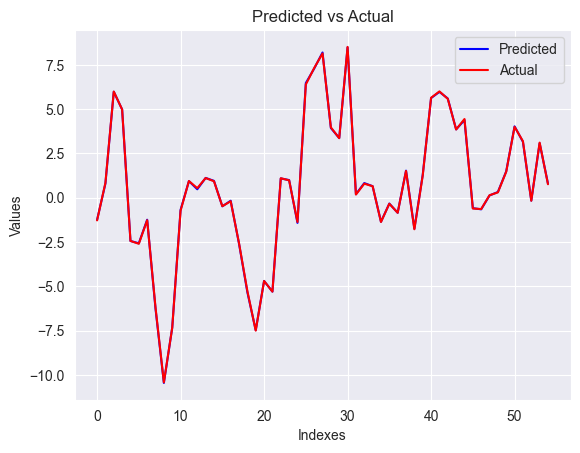

In [404]:
#plot best_iteration_
plot_target_graph(lgb_model, plot_dataset.data, plot_dataset.label)

In [412]:
ctb_params = dict(iterations=1200,
                  learning_rate=1.0,
                  depth=8,
                  l2_leaf_reg=30,
                  bootstrap_type='Bernoulli',
                  subsample=0.66,
                  loss_function='MAE',
                  eval_metric = 'MAE',
                  metric_period=100,
                  od_type='Iter',
                  od_wait=30,
                  task_type='GPU',
                  allow_writing_files=False,
                  )

print("Feature Elimination Performing.")
ctb_model = CatBoostRegressor(**ctb_params)

summary = ctb_model.select_features(
    BestNN_data_train[feature_name], BestNN_data_train_target,
    eval_set=[(BestNN_data_test[feature_name], BestNN_data_test_target)],
    features_for_select=feature_name,
    num_features_to_select=100,
    steps=3,
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
    shap_calc_type=EShapCalcType.Regular,
    train_final_model=False,
    plot=True,
)

print("Valid Model Training on Selected Features Subset.")
# ne znam jel treba dva put
ctb_model = CatBoostRegressor(**ctb_params)

ctb_model.fit(
    BestNN_data_train[summary['selected_features_names']], BestNN_data_train_target,
    eval_set=[(BestNN_data_test[summary['selected_features_names']], BestNN_data_test_target)],
    use_best_model=True,
)

predictions = ctb_model.predict(BestNN_data_test[summary['selected_features_names']])
score = mean_absolute_error(predictions, BestNN_data_test_target)
print(f"Score {np.round(score, 4)}")


Feature Elimination Performing.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Step #1 out of 3
0:	learn: 5.9420739	test: 4.4483018	best: 4.4483018 (0)	total: 175ms	remaining: 3m 29s
bestTest = 0.2950706898
bestIteration = 62
Shrink model to first 63 iterations.
Feature #27 eliminated
Feature #114 eliminated
Feature #38 eliminated
Feature #87 eliminated
Feature #100 eliminated
Feature #122 eliminated
Feature #0 eliminated
Feature #1 eliminated
Feature #2 eliminated
Feature #3 eliminated
Feature #4 eliminated
Feature #5 eliminated
Feature #6 eliminated
Feature #7 eliminated
Feature #8 eliminated
Feature #9 eliminated
Feature #11 eliminated
Feature #12 eliminated
Feature #14 eliminated
Feature #15 eliminated
Feature #16 eliminated
Feature #17 eliminated
Feature #19 eliminated
Feature #20 eliminated
Feature #21 eliminated
Feature #22 eliminated
Feature #23 eliminated
Feature #24 eliminated
Feature #25 eliminated
Feature #26 eliminated
Step #2 out of 3
0:	learn: 5.9419656	test: 4.4482290	best: 4.4482290 (0)	total: 46.8ms	remaining: 56.1s
bestTest = 0.2861499689
bestI

Valid Model Training on Selected Features Subset.
0:	learn: 5.9419526	test: 4.4482273	best: 4.4482273 (0)	total: 41.3ms	remaining: 49.6s
100:	learn: 0.4044205	test: 0.2897540	best: 0.2897540 (100)	total: 4.29s	remaining: 46.7s
bestTest = 0.2891755371
bestIteration = 160
Shrink model to first 161 iterations.
Score 0.2892


In [417]:
print(BestNN_data_plot[summary['selected_features_names']].shape, BestNN_data_plot_target.shape)

(55, 100) (55,)


In [418]:
y_pred = ctb_model.predict(BestNN_data_plot[summary['selected_features_names']])

In [419]:
print(y_pred)

[ -1.56615157   1.12513265   6.11993651   4.93222341  -2.46900845
  -2.68071274  -1.56605791  -6.21275675 -10.42111595  -7.65528436
  -1.10641791   1.12744486   0.69496036   0.84801099   1.12514186
  -0.1138043   -0.1137829   -2.68072174  -5.04530154  -7.65531476
  -4.26125433  -5.0453719    0.84798975   0.96621341  -1.56615157
   6.72745009   7.42512253   8.51921407   4.09953596   3.37936184
   8.88240521   0.43763052   0.97275624   0.69497186  -1.56616114
  -0.11419182  -1.10639714   1.38538646  -2.09972958   0.88144053
   5.96058936   6.11995552   5.9605474    3.90683536   4.58258894
  -1.03867083  -1.03849392   0.44142734   0.43899782   1.38456743
   4.09924375   3.37938085  -0.11375355   3.37938085   0.97262073]


In [431]:
y_test = BestNN_data_plot_target
y_test = np.array(y_test)
print(y_test)

[ -1.2797117    0.8404255    5.990267     4.980564    -2.4402142
  -2.5999546   -1.270175    -6.200075   -10.420084    -7.339716
  -0.7301569    0.9405613    0.5400181    1.1098385    0.92983246
  -0.4798174   -0.2002716   -2.5701523   -5.2702427   -7.5000525
  -4.6998262   -5.300045     1.1003017    0.97990036  -1.3697147
   6.389618     7.3194504    8.13961      3.9696693    3.3605099
   8.510351     0.18000603   0.7903576    0.6496906   -1.3697147
  -0.33974648  -0.84996223   1.5103817   -1.7797947    1.2505054
   5.6397915    5.9998035    5.580187     3.85046      4.440546
  -0.6097555   -0.6401539    0.13947487   0.3004074    1.4698505
   3.9994717    3.1900406   -0.16987324   3.1101704    0.76055527]


In [432]:
print(y_test.shape)

(55,)


(55,) (55,)


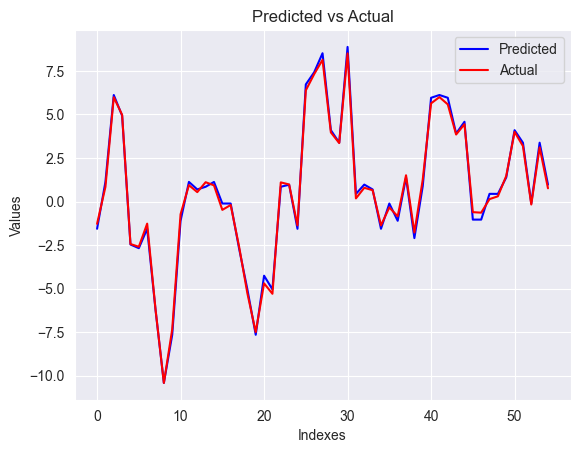

In [433]:
print(y_pred.shape, y_test.shape)
plt.plot(y_pred, color='blue', label='Predicted')
plt.plot(y_test, color='red', label='Actual')
plt.xlabel('Indexes')
plt.ylabel('Values')
plt.title('Predicted vs Actual')
plt.legend()
plt.show()